In [44]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

animals = dualanimalnames

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

In [45]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))#,'AE_267']))

In [46]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

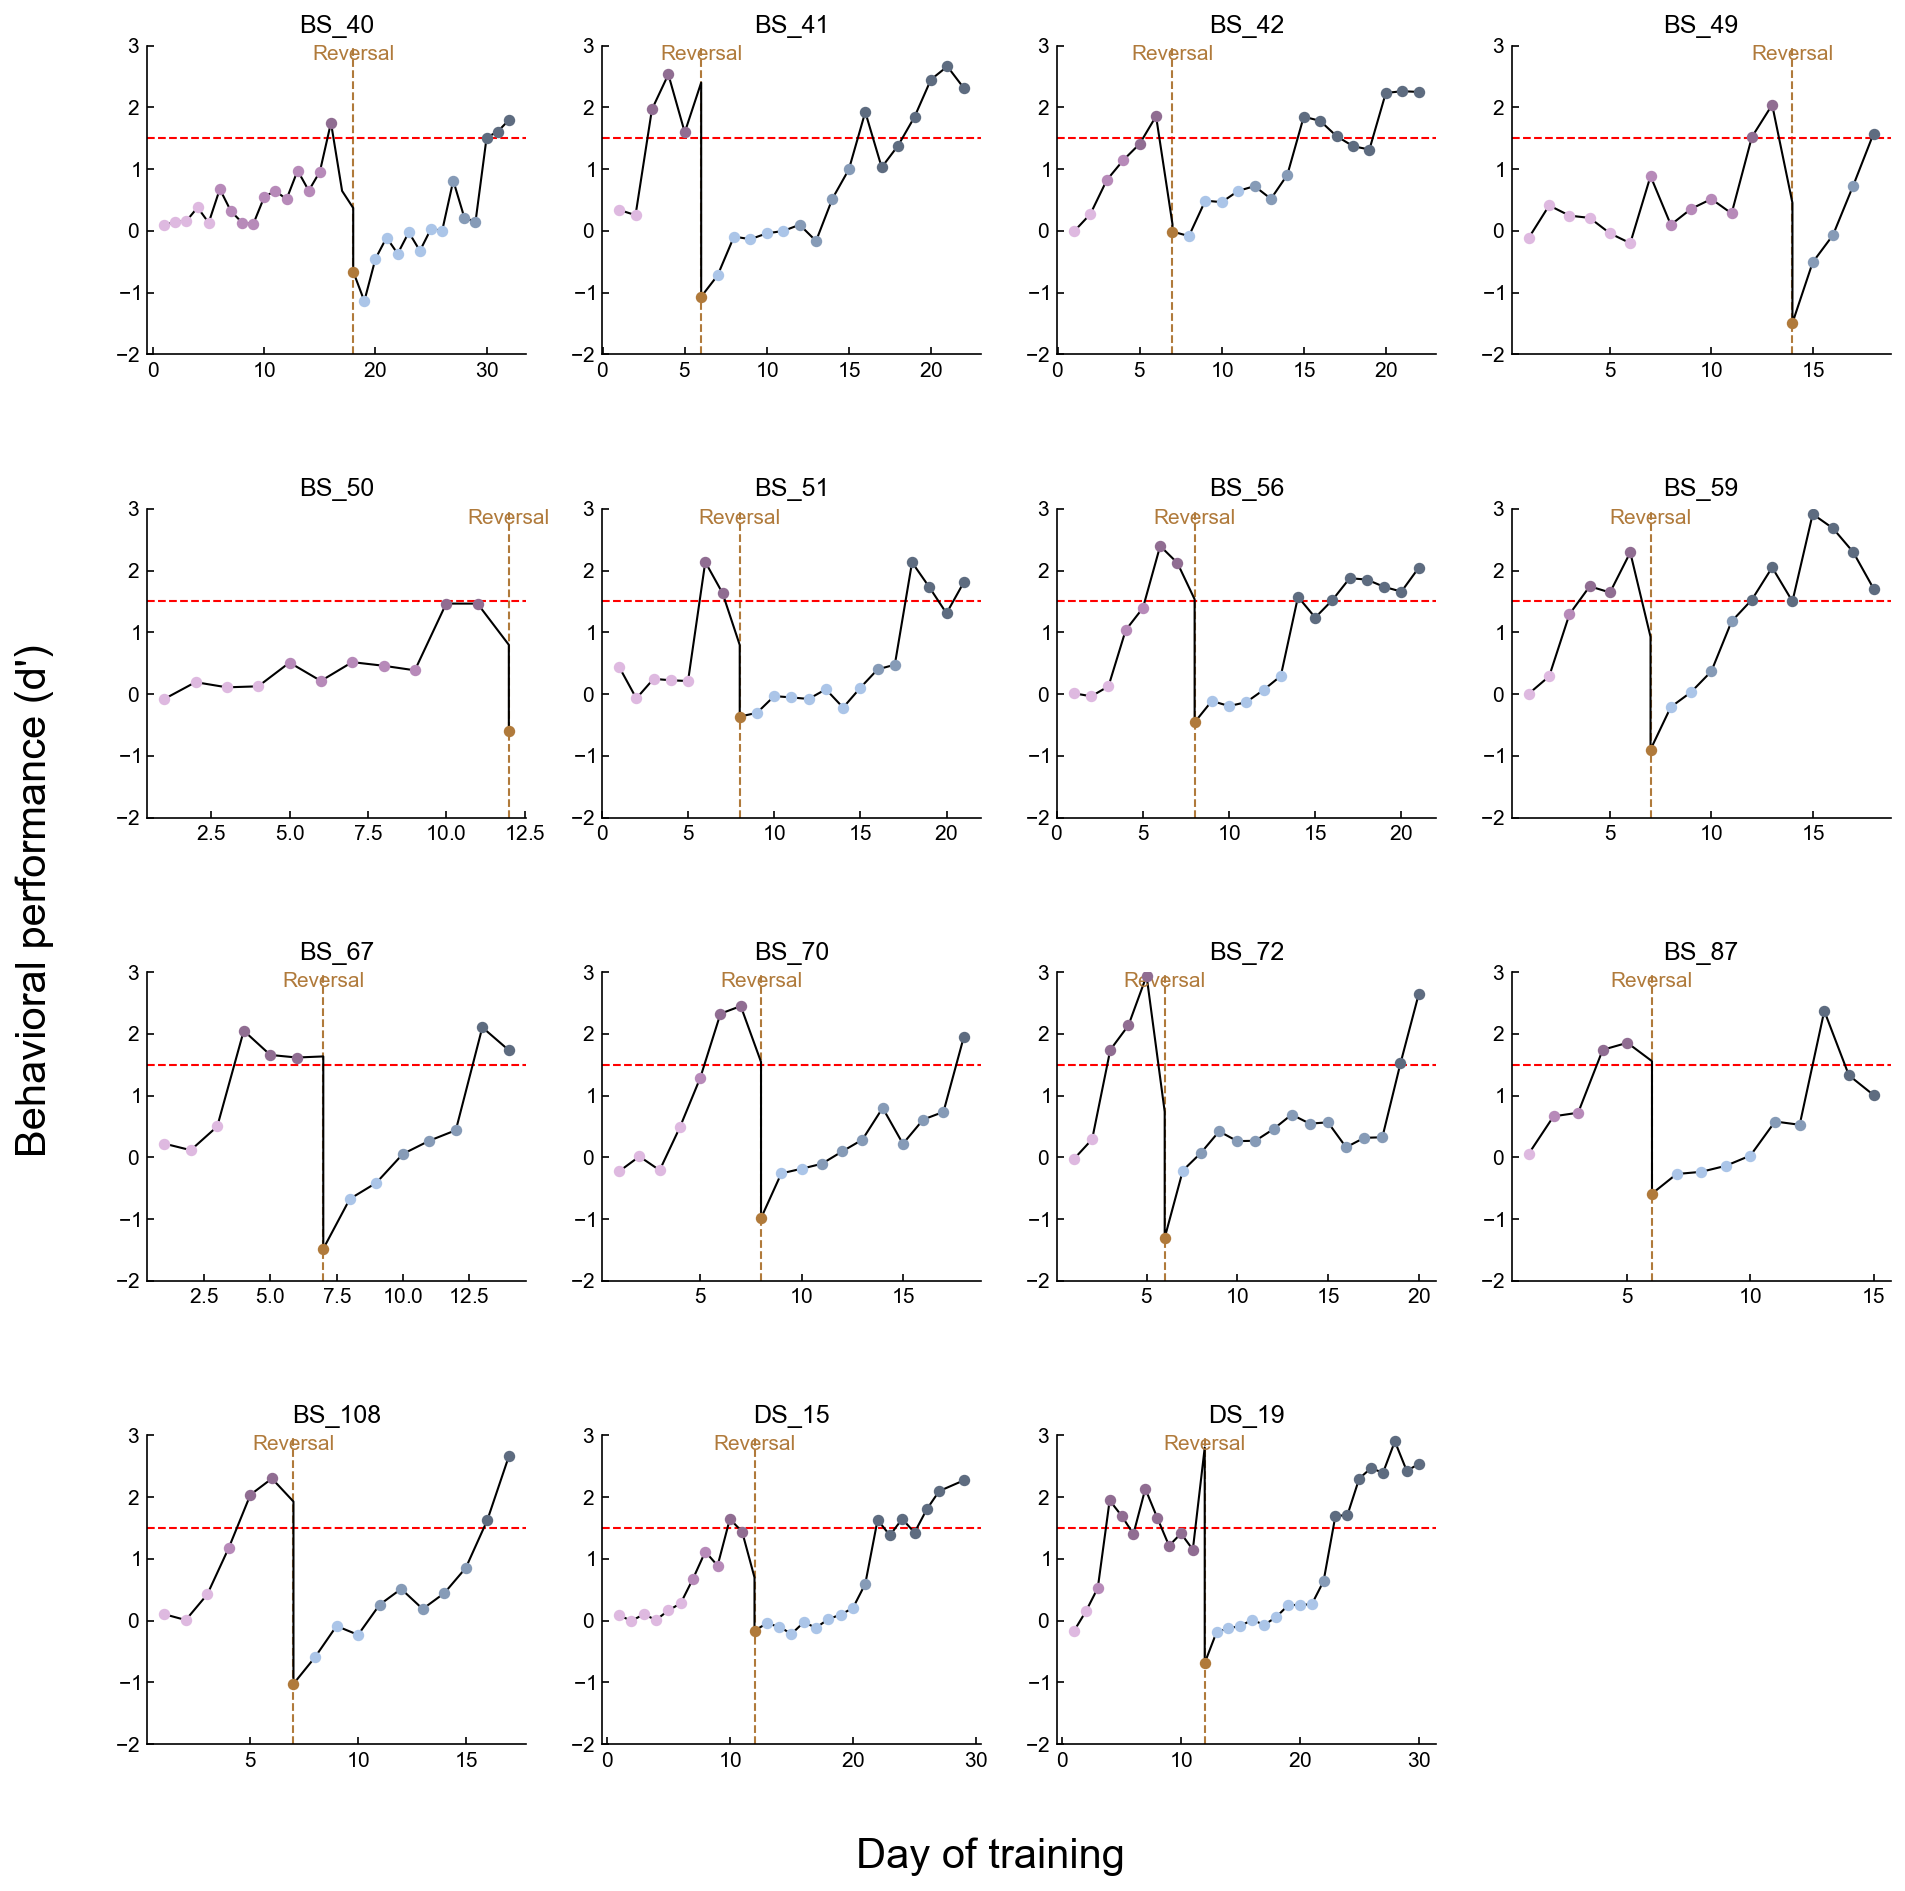

In [47]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [48]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 723/723 [00:10<00:00, 68.34it/s] 


In [50]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1830/1830 [00:26<00:00, 69.16it/s] 

errors for: []


In [78]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
res = dict()
for phase in phases:
    res[phase] = SimpleNamespace()
    res[phase].has = 0
    res[phase].nans = 0
    res[phase].hasnt = 0
    
for phase in phases:
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if sessionfile.meta.animal not in animals:
            continue

        if EILphases[idx] != phase:
            continue
        
        if hasattr(sessionfile.responsiveness[clust]['go'],'rampingSlopePerSec'):
            if np.isnan(sessionfile.responsiveness[clust]['go'].rampingSlopePerSec):
                res[phase].nans += 1
            else:
                res[phase].has += 1
                print(f"{session} clust {clust} should succeed")
        else:
            res[phase].hasnt += 1

676it [00:13, 72.50it/s] 

BS_49_1_AC.pickle clust 0 should succeed
BS_49_1_AC.pickle clust 4 should succeed
BS_49_1_AC.pickle clust 6 should succeed
BS_49_1_AC.pickle clust 8 should succeed
BS_49_1_AC.pickle clust 10 should succeed
BS_49_1_AC.pickle clust 11 should succeed
BS_49_1_AC.pickle clust 15 should succeed
BS_49_1_AC.pickle clust 23 should succeed


684it [00:13, 49.33it/s]

BS_49_1_AC.pickle clust 24 should succeed
BS_49_1_AC.pickle clust 29 should succeed
BS_49_1_AC.pickle clust 33 should succeed
BS_49_1_AC.pickle clust 34 should succeed
BS_49_1_AC.pickle clust 37 should succeed
BS_49_1_AC.pickle clust 46 should succeed
BS_49_1_AC.pickle clust 48 should succeed


691it [00:13, 44.31it/s]

BS_49_1_AC.pickle clust 49 should succeed
BS_49_1_AC.pickle clust 58 should succeed
BS_49_1_AC.pickle clust 66 should succeed
BS_49_1_AC.pickle clust 69 should succeed
BS_49_1_AC.pickle clust 71 should succeed
BS_49_1_AC.pickle clust 73 should succeed
BS_49_1_AC.pickle clust 74 should succeed
BS_49_1_AC.pickle clust 80 should succeed


697it [00:13, 41.26it/s]

BS_49_1_AC.pickle clust 81 should succeed
BS_49_1_AC.pickle clust 82 should succeed
BS_49_1_AC.pickle clust 83 should succeed
BS_49_1_AC.pickle clust 94 should succeed
BS_49_1_AC.pickle clust 96 should succeed


707it [00:14, 34.14it/s]

BS_49_1_AC.pickle clust 97 should succeed
BS_49_1_AC.pickle clust 105 should succeed
BS_49_1_AC.pickle clust 108 should succeed
BS_49_1_AC.pickle clust 111 should succeed
BS_49_1_AC.pickle clust 112 should succeed
BS_49_1_AC.pickle clust 113 should succeed


711it [00:14, 33.60it/s]

BS_49_1_AC.pickle clust 124 should succeed
BS_49_1_AC.pickle clust 129 should succeed
BS_49_1_AC.pickle clust 132 should succeed
BS_49_1_AC.pickle clust 133 should succeed
BS_49_1_AC.pickle clust 135 should succeed
BS_49_1_AC.pickle clust 143 should succeed


719it [00:14, 29.86it/s]

BS_49_1_AC.pickle clust 146 should succeed
BS_49_1_AC.pickle clust 150 should succeed
BS_49_1_AC.pickle clust 152 should succeed
BS_49_1_AC.pickle clust 157 should succeed
BS_49_1_AC.pickle clust 161 should succeed
BS_49_1_AC.pickle clust 162 should succeed


727it [00:14, 32.31it/s]

BS_49_1_AC.pickle clust 169 should succeed
BS_49_1_AC.pickle clust 178 should succeed


1830it [00:29, 61.32it/s] 
75it [00:01, 61.00it/s] 

BS_40_10_AC.pickle clust 5 should succeed
BS_40_10_AC.pickle clust 9 should succeed
BS_40_10_AC.pickle clust 20 should succeed
BS_40_10_AC.pickle clust 22 should succeed
BS_40_10_AC.pickle clust 23 should succeed
BS_40_10_AC.pickle clust 24 should succeed
BS_40_10_AC.pickle clust 25 should succeed
BS_40_10_AC.pickle clust 44 should succeed
BS_40_10_AC.pickle clust 50 should succeed
BS_40_10_AC.pickle clust 53 should succeed
BS_40_10_AC.pickle clust 55 should succeed


94it [00:01, 73.32it/s]

BS_40_10_AC.pickle clust 58 should succeed


184it [00:03, 107.36it/s]

BS_40_2_AC.pickle clust 15 should succeed
BS_40_2_AC.pickle clust 18 should succeed
BS_40_2_AC.pickle clust 30 should succeed
BS_40_2_AC.pickle clust 43 should succeed
BS_40_2_AC.pickle clust 46 should succeed
BS_40_2_AC.pickle clust 51 should succeed
BS_40_2_AC.pickle clust 56 should succeed
BS_40_2_AC.pickle clust 58 should succeed
BS_40_2_AC.pickle clust 61 should succeed
BS_40_2_AC.pickle clust 65 should succeed
BS_40_2_AC.pickle clust 66 should succeed


198it [00:03, 65.50it/s] 

BS_40_2_AC.pickle clust 70 should succeed
BS_40_2_AC.pickle clust 72 should succeed
BS_40_2_AC.pickle clust 83 should succeed
BS_40_2_AC.pickle clust 96 should succeed
BS_40_2_AC.pickle clust 97 should succeed
BS_40_2_AC.pickle clust 98 should succeed
BS_40_2_AC.pickle clust 103 should succeed


209it [00:04, 48.51it/s]

BS_40_2_AC.pickle clust 115 should succeed
BS_40_2_AC.pickle clust 124 should succeed
BS_40_2_AC.pickle clust 133 should succeed
BS_40_2_AC.pickle clust 142 should succeed


217it [00:04, 40.76it/s]

BS_40_2_AC.pickle clust 154 should succeed
BS_40_2_AC.pickle clust 162 should succeed
BS_40_2_AC.pickle clust 163 should succeed


224it [00:04, 38.40it/s]

BS_40_2_AC.pickle clust 165 should succeed
BS_40_2_AC.pickle clust 166 should succeed
BS_40_2_AC.pickle clust 184 should succeed
BS_40_2_AC.pickle clust 188 should succeed
BS_40_2_AC.pickle clust 189 should succeed
BS_40_2_AC.pickle clust 190 should succeed


230it [00:04, 36.94it/s]

BS_40_2_AC.pickle clust 194 should succeed
BS_40_2_AC.pickle clust 195 should succeed
BS_40_2_AC.pickle clust 201 should succeed
BS_40_2_AC.pickle clust 204 should succeed
BS_40_2_AC.pickle clust 206 should succeed
BS_40_2_AC.pickle clust 210 should succeed


235it [00:05, 32.47it/s]

BS_40_2_AC.pickle clust 211 should succeed
BS_40_2_AC.pickle clust 212 should succeed
BS_40_2_AC.pickle clust 213 should succeed
BS_40_2_AC.pickle clust 225 should succeed
BS_40_2_AC.pickle clust 230 should succeed


245it [00:05, 37.29it/s]

BS_40_2_AC.pickle clust 231 should succeed
BS_40_3_AC.pickle clust 0 should succeed
BS_40_3_AC.pickle clust 10 should succeed
BS_40_3_AC.pickle clust 14 should succeed
BS_40_3_AC.pickle clust 15 should succeed
BS_40_3_AC.pickle clust 23 should succeed
BS_40_3_AC.pickle clust 30 should succeed
BS_40_3_AC.pickle clust 37 should succeed
BS_40_3_AC.pickle clust 53 should succeed


256it [00:05, 38.56it/s]

BS_40_3_AC.pickle clust 57 should succeed
BS_40_3_AC.pickle clust 71 should succeed
BS_40_3_AC.pickle clust 81 should succeed
BS_40_3_AC.pickle clust 84 should succeed
BS_40_3_AC.pickle clust 105 should succeed


270it [00:05, 51.07it/s]

BS_40_3_AC.pickle clust 108 should succeed
BS_40_3_AC.pickle clust 115 should succeed
BS_40_3_AC.pickle clust 155 should succeed
BS_40_4_AC.pickle clust 0 should succeed
BS_40_4_AC.pickle clust 1 should succeed
BS_40_4_AC.pickle clust 7 should succeed
BS_40_4_AC.pickle clust 9 should succeed
BS_40_4_AC.pickle clust 10 should succeed


306it [00:05, 109.24it/s]

BS_40_4_AC.pickle clust 15 should succeed
BS_40_4_AC.pickle clust 18 should succeed
BS_40_4_AC.pickle clust 29 should succeed
BS_40_5_AC.pickle clust 5 should succeed
BS_40_5_AC.pickle clust 21 should succeed
BS_40_5_AC.pickle clust 22 should succeed
BS_40_5_AC.pickle clust 27 should succeed
BS_40_6_AC.pickle clust 4 should succeed
BS_40_6_AC.pickle clust 7 should succeed
BS_40_6_AC.pickle clust 10 should succeed
BS_40_6_AC.pickle clust 11 should succeed
BS_40_6_AC.pickle clust 15 should succeed
BS_40_6_AC.pickle clust 21 should succeed
BS_40_6_AC.pickle clust 24 should succeed
BS_40_6_AC.pickle clust 25 should succeed
BS_40_6_AC.pickle clust 26 should succeed
BS_40_6_AC.pickle clust 27 should succeed
BS_40_7_AC.pickle clust 23 should succeed
BS_40_7_AC.pickle clust 33 should succeed
BS_40_7_AC.pickle clust 36 should succeed
BS_40_7_AC.pickle clust 85 should succeed
BS_40_8_AC.pickle clust 6 should succeed
BS_40_8_AC.pickle clust 25 should succeed
BS_40_8_AC.pickle clust 33 should succ

676it [00:13, 76.98it/s] 

BS_49_10_AC.pickle clust 12 should succeed


808it [00:15, 135.69it/s]

BS_49_9_AC.pickle clust 15 should succeed
BS_49_9_AC.pickle clust 18 should succeed
BS_49_9_AC.pickle clust 27 should succeed
BS_49_9_AC.pickle clust 28 should succeed
BS_49_9_AC.pickle clust 33 should succeed
BS_49_9_AC.pickle clust 49 should succeed
BS_49_9_AC.pickle clust 61 should succeed


913it [00:16, 210.69it/s]

BS_70_1_AC.pickle clust 1 should succeed
BS_70_1_AC.pickle clust 13 should succeed
BS_70_1_AC.pickle clust 15 should succeed
BS_70_1_AC.pickle clust 31 should succeed
BS_70_1_AC.pickle clust 37 should succeed
BS_70_1_AC.pickle clust 42 should succeed
BS_70_1_AC.pickle clust 66 should succeed


935it [00:16, 128.86it/s]

BS_70_1_AC.pickle clust 77 should succeed
BS_70_1_AC.pickle clust 80 should succeed
BS_70_1_AC.pickle clust 88 should succeed
BS_70_1_AC.pickle clust 127 should succeed
BS_70_1_AC.pickle clust 140 should succeed


1830it [00:29, 61.38it/s] 
1633it [00:24, 108.36it/s]

DS_19_1_AC.pickle clust 1 should succeed
DS_19_1_AC.pickle clust 11 should succeed
DS_19_1_AC.pickle clust 14 should succeed
DS_19_1_AC.pickle clust 15 should succeed
DS_19_1_AC.pickle clust 41 should succeed
DS_19_1_AC.pickle clust 43 should succeed
DS_19_1_AC.pickle clust 65 should succeed
DS_19_1_AC.pickle clust 68 should succeed
DS_19_1_AC.pickle clust 88 should succeed
DS_19_1_AC.pickle clust 90 should succeed
DS_19_1_AC.pickle clust 91 should succeed
DS_19_1_AC.pickle clust 96 should succeed
DS_19_1_AC.pickle clust 106 should succeed


1830it [00:30, 60.55it/s] 
53it [00:01, 39.71it/s] 

BS_108_4_AC.pickle clust 93 should succeed
BS_108_6_AC.pickle clust 3 should succeed
BS_108_6_AC.pickle clust 9 should succeed
BS_108_6_AC.pickle clust 35 should succeed
BS_108_6_AC.pickle clust 38 should succeed
BS_108_6_AC.pickle clust 47 should succeed
BS_108_6_AC.pickle clust 48 should succeed
BS_108_6_AC.pickle clust 49 should succeed
BS_108_6_AC.pickle clust 50 should succeed
BS_108_6_AC.pickle clust 73 should succeed
BS_108_6_AC.pickle clust 76 should succeed


72it [00:01, 56.77it/s]

BS_108_6_AC.pickle clust 79 should succeed
BS_108_6_AC.pickle clust 82 should succeed
BS_108_6_AC.pickle clust 90 should succeed
BS_108_6_AC.pickle clust 125 should succeed
BS_108_6_AC.pickle clust 126 should succeed
BS_108_6_AC.pickle clust 133 should succeed


161it [00:03, 80.32it/s]

BS_40_15_AC.pickle clust 1 should succeed
BS_40_15_AC.pickle clust 3 should succeed
BS_40_15_AC.pickle clust 47 should succeed
BS_40_15_AC.pickle clust 68 should succeed
BS_40_16_AC.pickle clust 21 should succeed
BS_40_18_AC.pickle clust 2 should succeed
BS_40_18_AC.pickle clust 4 should succeed
BS_40_18_AC.pickle clust 19 should succeed
BS_40_18_AC.pickle clust 36 should succeed
BS_40_18_AC.pickle clust 41 should succeed
BS_40_18_AC.pickle clust 49 should succeed


368it [00:08, 33.28it/s] 

BS_41_2_AC.pickle clust 23 should succeed
BS_41_2_AC.pickle clust 52 should succeed
BS_41_2_AC.pickle clust 70 should succeed
BS_41_2_AC.pickle clust 119 should succeed
BS_41_2_AC.pickle clust 210 should succeed
BS_41_4_AC.pickle clust 0 should succeed
BS_41_4_AC.pickle clust 6 should succeed
BS_41_4_AC.pickle clust 8 should succeed
BS_41_4_AC.pickle clust 10 should succeed
BS_41_4_AC.pickle clust 17 should succeed
BS_41_4_AC.pickle clust 19 should succeed


374it [00:08, 35.85it/s]

BS_41_4_AC.pickle clust 20 should succeed
BS_41_4_AC.pickle clust 21 should succeed
BS_41_4_AC.pickle clust 38 should succeed
BS_41_4_AC.pickle clust 55 should succeed
BS_41_4_AC.pickle clust 57 should succeed
BS_41_4_AC.pickle clust 64 should succeed


385it [00:09, 36.29it/s]

BS_41_4_AC.pickle clust 66 should succeed
BS_41_4_AC.pickle clust 72 should succeed
BS_41_4_AC.pickle clust 73 should succeed
BS_41_4_AC.pickle clust 77 should succeed
BS_41_4_AC.pickle clust 84 should succeed
BS_41_4_AC.pickle clust 95 should succeed
BS_41_4_AC.pickle clust 96 should succeed
BS_41_4_AC.pickle clust 97 should succeed
BS_41_4_AC.pickle clust 100 should succeed


395it [00:09, 39.92it/s]

BS_41_4_AC.pickle clust 101 should succeed
BS_41_4_AC.pickle clust 109 should succeed
BS_41_4_AC.pickle clust 110 should succeed
BS_41_4_AC.pickle clust 114 should succeed
BS_41_4_AC.pickle clust 115 should succeed
BS_41_4_AC.pickle clust 117 should succeed
BS_41_4_AC.pickle clust 119 should succeed
BS_41_5_AC.pickle clust 2 should succeed
BS_41_5_AC.pickle clust 6 should succeed
BS_41_5_AC.pickle clust 13 should succeed
BS_41_5_AC.pickle clust 67 should succeed
BS_41_5_AC.pickle clust 68 should succeed
BS_41_5_AC.pickle clust 73 should succeed
BS_41_5_AC.pickle clust 85 should succeed


422it [00:09, 77.04it/s]

BS_41_6_AC.pickle clust 1 should succeed
BS_41_6_AC.pickle clust 3 should succeed
BS_41_6_AC.pickle clust 7 should succeed
BS_41_6_AC.pickle clust 32 should succeed


500it [00:10, 56.04it/s]

BS_42_2_AC.pickle clust 7 should succeed
BS_42_2_AC.pickle clust 8 should succeed
BS_42_2_AC.pickle clust 9 should succeed
BS_42_2_AC.pickle clust 12 should succeed
BS_42_2_AC.pickle clust 14 should succeed
BS_42_2_AC.pickle clust 15 should succeed
BS_42_2_AC.pickle clust 16 should succeed
BS_42_2_AC.pickle clust 17 should succeed
BS_42_2_AC.pickle clust 27 should succeed
BS_42_2_AC.pickle clust 41 should succeed
BS_42_2_AC.pickle clust 48 should succeed
BS_42_2_AC.pickle clust 54 should succeed


507it [00:10, 58.16it/s]

BS_42_2_AC.pickle clust 57 should succeed
BS_42_2_AC.pickle clust 61 should succeed
BS_42_2_AC.pickle clust 68 should succeed
BS_42_2_AC.pickle clust 69 should succeed
BS_42_2_AC.pickle clust 82 should succeed
BS_42_2_AC.pickle clust 84 should succeed


521it [00:11, 54.98it/s]

BS_42_2_AC.pickle clust 85 should succeed
BS_42_2_AC.pickle clust 86 should succeed
BS_42_2_AC.pickle clust 89 should succeed
BS_42_2_AC.pickle clust 100 should succeed
BS_42_2_AC.pickle clust 108 should succeed
BS_42_2_AC.pickle clust 118 should succeed
BS_42_2_AC.pickle clust 121 should succeed


537it [00:11, 64.55it/s]

BS_42_2_AC.pickle clust 135 should succeed
BS_42_3_AC.pickle clust 12 should succeed
BS_42_3_AC.pickle clust 19 should succeed
BS_42_3_AC.pickle clust 26 should succeed
BS_42_3_AC.pickle clust 47 should succeed
BS_42_3_AC.pickle clust 48 should succeed
BS_42_3_AC.pickle clust 49 should succeed
BS_42_3_AC.pickle clust 51 should succeed
BS_42_3_AC.pickle clust 53 should succeed
BS_42_3_AC.pickle clust 55 should succeed
BS_42_3_AC.pickle clust 56 should succeed
BS_42_3_AC.pickle clust 61 should succeed


554it [00:11, 66.54it/s]

BS_42_3_AC.pickle clust 63 should succeed
BS_42_3_AC.pickle clust 71 should succeed
BS_42_3_AC.pickle clust 73 should succeed
BS_42_3_AC.pickle clust 80 should succeed
BS_42_3_AC.pickle clust 99 should succeed
BS_42_3_AC.pickle clust 101 should succeed
BS_42_3_AC.pickle clust 102 should succeed
BS_42_3_AC.pickle clust 107 should succeed
BS_42_4_AC.pickle clust 0 should succeed
BS_42_4_AC.pickle clust 1 should succeed


569it [00:11, 59.17it/s]

BS_42_4_AC.pickle clust 7 should succeed
BS_42_4_AC.pickle clust 13 should succeed
BS_42_4_AC.pickle clust 16 should succeed
BS_42_4_AC.pickle clust 18 should succeed
BS_42_4_AC.pickle clust 26 should succeed
BS_42_4_AC.pickle clust 29 should succeed
BS_42_4_AC.pickle clust 36 should succeed
BS_42_4_AC.pickle clust 38 should succeed
BS_42_4_AC.pickle clust 40 should succeed
BS_42_4_AC.pickle clust 41 should succeed


576it [00:12, 56.57it/s]

BS_42_4_AC.pickle clust 42 should succeed
BS_42_4_AC.pickle clust 45 should succeed
BS_42_4_AC.pickle clust 46 should succeed
BS_42_4_AC.pickle clust 47 should succeed
BS_42_4_AC.pickle clust 48 should succeed
BS_42_4_AC.pickle clust 50 should succeed
BS_42_4_AC.pickle clust 51 should succeed


587it [00:12, 47.34it/s]

BS_42_4_AC.pickle clust 52 should succeed
BS_42_4_AC.pickle clust 58 should succeed
BS_42_4_AC.pickle clust 61 should succeed
BS_42_4_AC.pickle clust 62 should succeed
BS_42_4_AC.pickle clust 63 should succeed
BS_42_4_AC.pickle clust 65 should succeed
BS_42_4_AC.pickle clust 66 should succeed
BS_42_4_AC.pickle clust 68 should succeed
BS_42_4_AC.pickle clust 69 should succeed


606it [00:12, 80.33it/s]

BS_42_5_AC.pickle clust 3 should succeed
BS_42_5_AC.pickle clust 13 should succeed
BS_42_5_AC.pickle clust 20 should succeed
BS_42_5_AC.pickle clust 23 should succeed
BS_42_5_AC.pickle clust 24 should succeed
BS_42_5_AC.pickle clust 33 should succeed
BS_42_5_AC.pickle clust 38 should succeed
BS_42_5_AC.pickle clust 39 should succeed


963it [00:17, 108.43it/s]

BS_70_5_AC.pickle clust 3 should succeed
BS_70_5_AC.pickle clust 10 should succeed
BS_70_6_AC.pickle clust 2 should succeed
BS_70_6_AC.pickle clust 3 should succeed
BS_70_6_AC.pickle clust 14 should succeed
BS_70_6_AC.pickle clust 37 should succeed
BS_70_6_AC.pickle clust 42 should succeed
BS_70_6_AC.pickle clust 51 should succeed
BS_70_6_AC.pickle clust 52 should succeed
BS_70_6_AC.pickle clust 73 should succeed
BS_70_6_AC.pickle clust 74 should succeed
BS_70_6_AC.pickle clust 78 should succeed
BS_70_6_AC.pickle clust 81 should succeed


1066it [00:18, 116.03it/s]

BS_72_4_AC.pickle clust 0 should succeed
BS_72_4_AC.pickle clust 7 should succeed
BS_72_4_AC.pickle clust 9 should succeed
BS_72_4_AC.pickle clust 10 should succeed
BS_72_4_AC.pickle clust 12 should succeed
BS_72_4_AC.pickle clust 44 should succeed
BS_72_4_AC.pickle clust 68 should succeed


1090it [00:18, 94.25it/s] 

BS_72_4_AC.pickle clust 70 should succeed
BS_72_4_AC.pickle clust 79 should succeed
BS_72_4_AC.pickle clust 95 should succeed
BS_72_4_AC.pickle clust 115 should succeed


1167it [00:19, 137.29it/s]

BS_87_4_AC.pickle clust 3 should succeed
BS_87_4_AC.pickle clust 10 should succeed
BS_87_4_AC.pickle clust 15 should succeed
BS_87_4_AC.pickle clust 18 should succeed
BS_87_4_AC.pickle clust 19 should succeed
BS_87_4_AC.pickle clust 26 should succeed
BS_87_4_AC.pickle clust 27 should succeed
BS_87_4_AC.pickle clust 33 should succeed
BS_87_4_AC.pickle clust 34 should succeed
BS_87_4_AC.pickle clust 35 should succeed


1182it [00:19, 89.40it/s] 

BS_87_4_AC.pickle clust 38 should succeed
BS_87_4_AC.pickle clust 44 should succeed
BS_87_4_AC.pickle clust 45 should succeed
BS_87_4_AC.pickle clust 57 should succeed
BS_87_4_AC.pickle clust 63 should succeed
BS_87_4_AC.pickle clust 73 should succeed
BS_87_4_AC.pickle clust 99 should succeed
BS_87_4_AC.pickle clust 124 should succeed
BS_87_4_AC.pickle clust 125 should succeed
BS_87_4_AC.pickle clust 141 should succeed
BS_87_4_AC.pickle clust 142 should succeed
BS_87_4_AC.pickle clust 145 should succeed
BS_87_4_AC.pickle clust 154 should succeed
BS_87_4_AC.pickle clust 156 should succeed
BS_87_4_AC.pickle clust 162 should succeed


1194it [00:19, 66.18it/s]

BS_87_4_AC.pickle clust 166 should succeed
BS_87_4_AC.pickle clust 172 should succeed
BS_87_4_AC.pickle clust 181 should succeed
BS_87_4_AC.pickle clust 187 should succeed
BS_87_4_AC.pickle clust 211 should succeed
BS_87_4_AC.pickle clust 216 should succeed
BS_87_4_AC.pickle clust 219 should succeed
BS_87_4_AC.pickle clust 260 should succeed
BS_87_4_AC.pickle clust 267 should succeed


1213it [00:20, 61.92it/s]

BS_87_5_AC.pickle clust 7 should succeed
BS_87_5_AC.pickle clust 11 should succeed
BS_87_5_AC.pickle clust 14 should succeed
BS_87_5_AC.pickle clust 16 should succeed
BS_87_5_AC.pickle clust 24 should succeed
BS_87_5_AC.pickle clust 25 should succeed
BS_87_5_AC.pickle clust 30 should succeed


1228it [00:20, 58.65it/s]

BS_87_5_AC.pickle clust 35 should succeed
BS_87_5_AC.pickle clust 37 should succeed
BS_87_5_AC.pickle clust 42 should succeed
BS_87_5_AC.pickle clust 43 should succeed
BS_87_5_AC.pickle clust 47 should succeed
BS_87_5_AC.pickle clust 52 should succeed
BS_87_5_AC.pickle clust 53 should succeed
BS_87_5_AC.pickle clust 55 should succeed
BS_87_5_AC.pickle clust 83 should succeed
BS_87_5_AC.pickle clust 84 should succeed
BS_87_5_AC.pickle clust 87 should succeed
BS_87_5_AC.pickle clust 93 should succeed
BS_87_5_AC.pickle clust 97 should succeed


1260it [00:20, 100.82it/s]

BS_87_5_AC.pickle clust 99 should succeed
BS_87_6_AC.pickle clust 3 should succeed
BS_87_6_AC.pickle clust 7 should succeed
BS_87_6_AC.pickle clust 16 should succeed
BS_87_6_AC.pickle clust 40 should succeed
BS_87_6_AC.pickle clust 44 should succeed
BS_87_6_AC.pickle clust 62 should succeed
BS_87_6_AC.pickle clust 70 should succeed
BS_87_6_AC.pickle clust 87 should succeed
BS_87_6_AC.pickle clust 98 should succeed
BS_87_7_AC.pickle clust 6 should succeed
BS_87_7_AC.pickle clust 9 should succeed
BS_87_7_AC.pickle clust 11 should succeed


1492it [00:23, 103.16it/s]

DS_15_3_AC.pickle clust 3 should succeed
DS_15_3_AC.pickle clust 21 should succeed
DS_15_3_AC.pickle clust 22 should succeed
DS_15_3_AC.pickle clust 23 should succeed
DS_15_3_AC.pickle clust 28 should succeed
DS_15_3_AC.pickle clust 30 should succeed
DS_15_3_AC.pickle clust 37 should succeed
DS_15_3_AC.pickle clust 39 should succeed
DS_15_3_AC.pickle clust 43 should succeed
DS_15_3_AC.pickle clust 54 should succeed
DS_15_3_AC.pickle clust 56 should succeed
DS_15_3_AC.pickle clust 58 should succeed
DS_15_3_AC.pickle clust 65 should succeed
DS_15_3_AC.pickle clust 67 should succeed
DS_15_3_AC.pickle clust 89 should succeed


1513it [00:23, 91.52it/s] 

DS_15_3_AC.pickle clust 92 should succeed
DS_15_4_AC.pickle clust 3 should succeed
DS_15_4_AC.pickle clust 19 should succeed
DS_15_4_AC.pickle clust 20 should succeed
DS_15_5_AC.pickle clust 18 should succeed
DS_15_6_AC.pickle clust 0 should succeed
DS_15_6_AC.pickle clust 8 should succeed
DS_15_6_AC.pickle clust 9 should succeed
DS_15_6_AC.pickle clust 19 should succeed
DS_15_6_AC.pickle clust 25 should succeed
DS_15_6_AC.pickle clust 26 should succeed
DS_15_6_AC.pickle clust 37 should succeed
DS_15_6_AC.pickle clust 39 should succeed
DS_15_6_AC.pickle clust 47 should succeed


1523it [00:23, 89.14it/s]

DS_15_6_AC.pickle clust 53 should succeed
DS_15_6_AC.pickle clust 58 should succeed
DS_15_6_AC.pickle clust 64 should succeed
DS_15_7_AC.pickle clust 3 should succeed
DS_15_7_AC.pickle clust 15 should succeed
DS_15_7_AC.pickle clust 28 should succeed
DS_15_7_AC.pickle clust 42 should succeed
DS_15_7_AC.pickle clust 74 should succeed
DS_15_8_AC.pickle clust 0 should succeed
DS_15_8_AC.pickle clust 7 should succeed
DS_15_8_AC.pickle clust 9 should succeed
DS_15_8_AC.pickle clust 16 should succeed
DS_15_8_AC.pickle clust 21 should succeed
DS_15_8_AC.pickle clust 22 should succeed
DS_15_8_AC.pickle clust 28 should succeed
DS_15_8_AC.pickle clust 31 should succeed
DS_15_8_AC.pickle clust 38 should succeed
DS_15_9_AC.pickle clust 45 should succeed


1569it [00:24, 127.04it/s]

DS_15_9_AC.pickle clust 77 should succeed
DS_15_9_AC.pickle clust 116 should succeed
DS_15_9_AC.pickle clust 129 should succeed
DS_15_9_AC.pickle clust 134 should succeed
DS_15_9_AC.pickle clust 135 should succeed
DS_15_9_AC.pickle clust 138 should succeed
DS_15_9_AC.pickle clust 148 should succeed
DS_15_9_AC.pickle clust 153 should succeed
DS_15_9_AC.pickle clust 161 should succeed
DS_19_10_AC.pickle clust 12 should succeed
DS_19_10_AC.pickle clust 22 should succeed
DS_19_10_AC.pickle clust 24 should succeed
DS_19_10_AC.pickle clust 25 should succeed
DS_19_11_AC.pickle clust 14 should succeed
DS_19_11_AC.pickle clust 25 should succeed
DS_19_11_AC.pickle clust 44 should succeed
DS_19_11_AC.pickle clust 45 should succeed
DS_19_11_AC.pickle clust 47 should succeed
DS_19_11_AC.pickle clust 49 should succeed


1667it [00:25, 44.21it/s] 

DS_19_3_AC.pickle clust 9 should succeed
DS_19_3_AC.pickle clust 11 should succeed
DS_19_3_AC.pickle clust 18 should succeed
DS_19_3_AC.pickle clust 20 should succeed
DS_19_3_AC.pickle clust 22 should succeed
DS_19_3_AC.pickle clust 25 should succeed
DS_19_3_AC.pickle clust 33 should succeed
DS_19_3_AC.pickle clust 43 should succeed
DS_19_3_AC.pickle clust 49 should succeed
DS_19_3_AC.pickle clust 52 should succeed
DS_19_3_AC.pickle clust 56 should succeed
DS_19_3_AC.pickle clust 59 should succeed


1673it [00:26, 45.90it/s]

DS_19_3_AC.pickle clust 64 should succeed
DS_19_3_AC.pickle clust 65 should succeed
DS_19_3_AC.pickle clust 72 should succeed
DS_19_3_AC.pickle clust 74 should succeed
DS_19_3_AC.pickle clust 76 should succeed
DS_19_3_AC.pickle clust 79 should succeed
DS_19_3_AC.pickle clust 95 should succeed
DS_19_3_AC.pickle clust 106 should succeed
DS_19_3_AC.pickle clust 108 should succeed
DS_19_3_AC.pickle clust 115 should succeed


1685it [00:26, 42.62it/s]

DS_19_3_AC.pickle clust 119 should succeed
DS_19_3_AC.pickle clust 123 should succeed
DS_19_4_AC.pickle clust 8 should succeed
DS_19_4_AC.pickle clust 12 should succeed
DS_19_4_AC.pickle clust 20 should succeed
DS_19_4_AC.pickle clust 22 should succeed


1697it [00:26, 47.24it/s]

DS_19_4_AC.pickle clust 23 should succeed
DS_19_4_AC.pickle clust 32 should succeed
DS_19_4_AC.pickle clust 33 should succeed
DS_19_4_AC.pickle clust 56 should succeed
DS_19_4_AC.pickle clust 60 should succeed
DS_19_4_AC.pickle clust 75 should succeed
DS_19_4_AC.pickle clust 80 should succeed
DS_19_4_AC.pickle clust 81 should succeed


1703it [00:26, 46.93it/s]

DS_19_4_AC.pickle clust 84 should succeed
DS_19_4_AC.pickle clust 87 should succeed
DS_19_4_AC.pickle clust 99 should succeed
DS_19_4_AC.pickle clust 110 should succeed
DS_19_5_AC.pickle clust 5 should succeed
DS_19_5_AC.pickle clust 7 should succeed
DS_19_5_AC.pickle clust 13 should succeed


1709it [00:26, 42.39it/s]

DS_19_5_AC.pickle clust 23 should succeed
DS_19_5_AC.pickle clust 24 should succeed
DS_19_5_AC.pickle clust 25 should succeed
DS_19_5_AC.pickle clust 30 should succeed
DS_19_5_AC.pickle clust 53 should succeed
DS_19_5_AC.pickle clust 59 should succeed
DS_19_5_AC.pickle clust 60 should succeed
DS_19_5_AC.pickle clust 61 should succeed


1719it [00:27, 37.95it/s]

DS_19_5_AC.pickle clust 68 should succeed
DS_19_5_AC.pickle clust 73 should succeed
DS_19_5_AC.pickle clust 132 should succeed
DS_19_5_AC.pickle clust 136 should succeed
DS_19_5_AC.pickle clust 137 should succeed


1723it [00:27, 31.00it/s]

DS_19_5_AC.pickle clust 141 should succeed
DS_19_5_AC.pickle clust 151 should succeed
DS_19_5_AC.pickle clust 152 should succeed
DS_19_5_AC.pickle clust 154 should succeed


1731it [00:27, 30.75it/s]

DS_19_5_AC.pickle clust 161 should succeed
DS_19_5_AC.pickle clust 182 should succeed
DS_19_5_AC.pickle clust 211 should succeed
DS_19_5_AC.pickle clust 212 should succeed
DS_19_5_AC.pickle clust 213 should succeed
DS_19_5_AC.pickle clust 218 should succeed


1739it [00:27, 30.25it/s]

DS_19_6_AC.pickle clust 0 should succeed
DS_19_6_AC.pickle clust 2 should succeed
DS_19_6_AC.pickle clust 3 should succeed
DS_19_6_AC.pickle clust 8 should succeed
DS_19_6_AC.pickle clust 10 should succeed
DS_19_6_AC.pickle clust 12 should succeed
DS_19_6_AC.pickle clust 25 should succeed


1747it [00:28, 29.56it/s]

DS_19_6_AC.pickle clust 31 should succeed
DS_19_6_AC.pickle clust 40 should succeed
DS_19_6_AC.pickle clust 45 should succeed
DS_19_6_AC.pickle clust 51 should succeed
DS_19_6_AC.pickle clust 54 should succeed
DS_19_6_AC.pickle clust 77 should succeed
DS_19_6_AC.pickle clust 103 should succeed


1753it [00:28, 25.84it/s]

DS_19_6_AC.pickle clust 109 should succeed
DS_19_6_AC.pickle clust 121 should succeed
DS_19_6_AC.pickle clust 134 should succeed
DS_19_6_AC.pickle clust 142 should succeed
DS_19_6_AC.pickle clust 144 should succeed
DS_19_6_AC.pickle clust 166 should succeed


1759it [00:28, 27.22it/s]

DS_19_6_AC.pickle clust 173 should succeed
DS_19_6_AC.pickle clust 191 should succeed
DS_19_6_AC.pickle clust 214 should succeed
DS_19_6_AC.pickle clust 217 should succeed
DS_19_6_AC.pickle clust 220 should succeed


1765it [00:28, 27.98it/s]

DS_19_6_AC.pickle clust 228 should succeed
DS_19_6_AC.pickle clust 229 should succeed
DS_19_6_AC.pickle clust 232 should succeed
DS_19_6_AC.pickle clust 234 should succeed
DS_19_6_AC.pickle clust 238 should succeed
DS_19_6_AC.pickle clust 245 should succeed


1771it [00:29, 28.05it/s]

DS_19_6_AC.pickle clust 253 should succeed
DS_19_6_AC.pickle clust 257 should succeed
DS_19_6_AC.pickle clust 262 should succeed
DS_19_6_AC.pickle clust 263 should succeed
DS_19_6_AC.pickle clust 264 should succeed


1779it [00:29, 30.40it/s]

DS_19_6_AC.pickle clust 265 should succeed
DS_19_6_AC.pickle clust 266 should succeed
DS_19_7_AC.pickle clust 10 should succeed
DS_19_7_AC.pickle clust 13 should succeed
DS_19_7_AC.pickle clust 15 should succeed
DS_19_7_AC.pickle clust 16 should succeed
DS_19_7_AC.pickle clust 19 should succeed
DS_19_7_AC.pickle clust 28 should succeed
DS_19_7_AC.pickle clust 30 should succeed


1790it [00:29, 40.31it/s]

DS_19_7_AC.pickle clust 37 should succeed
DS_19_7_AC.pickle clust 39 should succeed
DS_19_7_AC.pickle clust 41 should succeed
DS_19_7_AC.pickle clust 45 should succeed
DS_19_7_AC.pickle clust 48 should succeed
DS_19_7_AC.pickle clust 49 should succeed
DS_19_7_AC.pickle clust 66 should succeed
DS_19_7_AC.pickle clust 76 should succeed
DS_19_7_AC.pickle clust 85 should succeed
DS_19_7_AC.pickle clust 88 should succeed
DS_19_7_AC.pickle clust 89 should succeed


1800it [00:29, 40.64it/s]

DS_19_8_AC.pickle clust 2 should succeed
DS_19_8_AC.pickle clust 3 should succeed
DS_19_8_AC.pickle clust 4 should succeed
DS_19_8_AC.pickle clust 6 should succeed
DS_19_8_AC.pickle clust 9 should succeed
DS_19_8_AC.pickle clust 10 should succeed
DS_19_8_AC.pickle clust 48 should succeed


1805it [00:30, 40.24it/s]

DS_19_8_AC.pickle clust 49 should succeed
DS_19_8_AC.pickle clust 54 should succeed
DS_19_8_AC.pickle clust 57 should succeed
DS_19_8_AC.pickle clust 61 should succeed
DS_19_8_AC.pickle clust 78 should succeed
DS_19_8_AC.pickle clust 79 should succeed
DS_19_8_AC.pickle clust 84 should succeed
DS_19_8_AC.pickle clust 90 should succeed
DS_19_8_AC.pickle clust 96 should succeed


1815it [00:30, 33.06it/s]

DS_19_8_AC.pickle clust 118 should succeed
DS_19_8_AC.pickle clust 128 should succeed
DS_19_8_AC.pickle clust 134 should succeed
DS_19_8_AC.pickle clust 138 should succeed


1823it [00:30, 35.55it/s]

DS_19_8_AC.pickle clust 143 should succeed
DS_19_8_AC.pickle clust 155 should succeed
DS_19_8_AC.pickle clust 156 should succeed
DS_19_8_AC.pickle clust 162 should succeed
DS_19_8_AC.pickle clust 163 should succeed
DS_19_8_AC.pickle clust 164 should succeed
DS_19_9_AC.pickle clust 15 should succeed
DS_19_9_AC.pickle clust 18 should succeed
DS_19_9_AC.pickle clust 53 should succeed


1830it [00:30, 59.77it/s]
13it [00:00, 108.31it/s]

DS_19_9_AC.pickle clust 56 should succeed
DS_19_9_AC.pickle clust 57 should succeed
DS_19_9_AC.pickle clust 62 should succeed
DS_19_9_AC.pickle clust 68 should succeed


175it [00:03, 94.97it/s]

BS_40_19_AC.pickle clust 1 should succeed
BS_40_19_AC.pickle clust 3 should succeed
BS_40_19_AC.pickle clust 6 should succeed
BS_40_19_AC.pickle clust 8 should succeed
BS_40_19_AC.pickle clust 19 should succeed
BS_40_19_AC.pickle clust 22 should succeed
BS_40_19_AC.pickle clust 31 should succeed
BS_40_19_AC.pickle clust 34 should succeed
BS_40_19_AC.pickle clust 46 should succeed
BS_40_19_AC.pickle clust 47 should succeed
BS_40_19_AC.pickle clust 48 should succeed


428it [00:09, 80.03it/s] 

BS_41_7_AC.pickle clust 0 should succeed
BS_41_7_AC.pickle clust 24 should succeed
BS_41_7_AC.pickle clust 50 should succeed
BS_41_7_AC.pickle clust 54 should succeed
BS_41_7_AC.pickle clust 55 should succeed
BS_41_7_AC.pickle clust 57 should succeed
BS_41_7_AC.pickle clust 59 should succeed
BS_41_7_AC.pickle clust 62 should succeed
BS_41_7_AC.pickle clust 63 should succeed
BS_41_7_AC.pickle clust 64 should succeed
BS_41_7_AC.pickle clust 73 should succeed
BS_41_7_AC.pickle clust 76 should succeed
BS_41_7_AC.pickle clust 96 should succeed
BS_41_8_AC.pickle clust 13 should succeed
BS_41_8_AC.pickle clust 15 should succeed
BS_41_8_AC.pickle clust 16 should succeed


437it [00:09, 78.23it/s]

BS_41_8_AC.pickle clust 17 should succeed
BS_41_8_AC.pickle clust 25 should succeed
BS_41_8_AC.pickle clust 40 should succeed
BS_41_8_AC.pickle clust 49 should succeed
BS_41_8_AC.pickle clust 57 should succeed
BS_41_8_AC.pickle clust 58 should succeed
BS_41_8_AC.pickle clust 59 should succeed
BS_41_8_AC.pickle clust 60 should succeed
BS_41_8_AC.pickle clust 61 should succeed
BS_41_8_AC.pickle clust 66 should succeed
BS_41_8_AC.pickle clust 67 should succeed
BS_41_8_AC.pickle clust 69 should succeed
BS_41_8_AC.pickle clust 72 should succeed
BS_41_8_AC.pickle clust 77 should succeed
BS_41_8_AC.pickle clust 79 should succeed


457it [00:09, 84.46it/s]

BS_41_8_AC.pickle clust 82 should succeed
BS_41_8_AC.pickle clust 89 should succeed
BS_41_9_AC.pickle clust 3 should succeed
BS_41_9_AC.pickle clust 23 should succeed
BS_41_9_AC.pickle clust 24 should succeed
BS_41_9_AC.pickle clust 37 should succeed
BS_41_9_AC.pickle clust 70 should succeed
BS_41_9_AC.pickle clust 80 should succeed
BS_41_9_AC.pickle clust 102 should succeed
BS_41_9_AC.pickle clust 103 should succeed
BS_41_9_AC.pickle clust 109 should succeed
BS_41_9_AC.pickle clust 125 should succeed


624it [00:12, 98.21it/s]

BS_42_6_AC.pickle clust 70 should succeed
BS_42_7_AC.pickle clust 0 should succeed
BS_42_7_AC.pickle clust 1 should succeed
BS_42_7_AC.pickle clust 23 should succeed
BS_42_7_AC.pickle clust 24 should succeed
BS_42_7_AC.pickle clust 25 should succeed
BS_42_7_AC.pickle clust 26 should succeed
BS_42_7_AC.pickle clust 33 should succeed


635it [00:12, 75.47it/s]

BS_42_7_AC.pickle clust 35 should succeed
BS_42_7_AC.pickle clust 42 should succeed
BS_42_7_AC.pickle clust 45 should succeed
BS_42_7_AC.pickle clust 46 should succeed
BS_42_7_AC.pickle clust 47 should succeed
BS_42_7_AC.pickle clust 49 should succeed
BS_42_7_AC.pickle clust 50 should succeed


644it [00:12, 55.40it/s]

BS_42_7_AC.pickle clust 52 should succeed
BS_42_7_AC.pickle clust 53 should succeed
BS_42_7_AC.pickle clust 58 should succeed
BS_42_7_AC.pickle clust 64 should succeed
BS_42_7_AC.pickle clust 65 should succeed
BS_42_7_AC.pickle clust 66 should succeed
BS_42_7_AC.pickle clust 69 should succeed
BS_42_7_AC.pickle clust 71 should succeed
BS_42_7_AC.pickle clust 72 should succeed


659it [00:13, 50.78it/s]

BS_42_7_AC.pickle clust 73 should succeed
BS_42_7_AC.pickle clust 84 should succeed
BS_42_7_AC.pickle clust 89 should succeed
BS_42_7_AC.pickle clust 93 should succeed
BS_42_7_AC.pickle clust 100 should succeed
BS_42_7_AC.pickle clust 117 should succeed
BS_42_7_AC.pickle clust 119 should succeed
BS_42_7_AC.pickle clust 124 should succeed


676it [00:13, 70.10it/s]

BS_49_14_AC.pickle clust 16 should succeed


913it [00:16, 209.34it/s]

BS_67_1_AC.pickle clust 10 should succeed
BS_67_1_AC.pickle clust 14 should succeed
BS_67_1_AC.pickle clust 16 should succeed
BS_67_1_AC.pickle clust 19 should succeed
BS_67_1_AC.pickle clust 31 should succeed
BS_67_1_AC.pickle clust 55 should succeed
BS_67_1_AC.pickle clust 59 should succeed
BS_70_10_AC.pickle clust 16 should succeed
BS_70_10_AC.pickle clust 19 should succeed
BS_70_10_AC.pickle clust 37 should succeed
BS_70_11_AC.pickle clust 14 should succeed
BS_70_11_AC.pickle clust 15 should succeed
BS_70_11_AC.pickle clust 18 should succeed
BS_70_11_AC.pickle clust 23 should succeed
BS_70_11_AC.pickle clust 32 should succeed
BS_70_11_AC.pickle clust 35 should succeed
BS_70_11_AC.pickle clust 37 should succeed
BS_70_11_AC.pickle clust 38 should succeed


984it [00:17, 124.95it/s]

BS_70_8_AC.pickle clust 3 should succeed
BS_70_8_AC.pickle clust 21 should succeed
BS_70_8_AC.pickle clust 32 should succeed
BS_70_8_AC.pickle clust 52 should succeed
BS_70_9_AC.pickle clust 8 should succeed
BS_70_9_AC.pickle clust 9 should succeed


1021it [00:17, 126.31it/s]

BS_70_9_AC.pickle clust 14 should succeed
BS_70_9_AC.pickle clust 15 should succeed
BS_70_9_AC.pickle clust 20 should succeed
BS_70_9_AC.pickle clust 21 should succeed
BS_70_9_AC.pickle clust 34 should succeed
BS_70_9_AC.pickle clust 35 should succeed
BS_70_9_AC.pickle clust 36 should succeed
BS_70_9_AC.pickle clust 38 should succeed
BS_70_9_AC.pickle clust 40 should succeed
BS_70_9_AC.pickle clust 41 should succeed
BS_70_9_AC.pickle clust 48 should succeed
BS_70_9_AC.pickle clust 54 should succeed
BS_70_9_AC.pickle clust 56 should succeed
BS_70_9_AC.pickle clust 60 should succeed
BS_72_13_AC.pickle clust 0 should succeed
BS_72_13_AC.pickle clust 12 should succeed


1104it [00:18, 99.98it/s] 

BS_72_5_AC.pickle clust 10 should succeed
BS_72_5_AC.pickle clust 36 should succeed
BS_72_5_AC.pickle clust 37 should succeed
BS_72_5_AC.pickle clust 42 should succeed
BS_72_5_AC.pickle clust 54 should succeed
BS_72_5_AC.pickle clust 61 should succeed
BS_72_6_AC.pickle clust 0 should succeed
BS_72_6_AC.pickle clust 7 should succeed
BS_72_6_AC.pickle clust 12 should succeed
BS_72_6_AC.pickle clust 13 should succeed


1115it [00:18, 85.48it/s]

BS_72_6_AC.pickle clust 14 should succeed
BS_72_6_AC.pickle clust 17 should succeed
BS_72_6_AC.pickle clust 22 should succeed
BS_72_6_AC.pickle clust 23 should succeed
BS_72_6_AC.pickle clust 26 should succeed
BS_72_6_AC.pickle clust 27 should succeed
BS_72_6_AC.pickle clust 28 should succeed
BS_72_6_AC.pickle clust 29 should succeed
BS_72_6_AC.pickle clust 31 should succeed
BS_72_6_AC.pickle clust 32 should succeed
BS_72_6_AC.pickle clust 40 should succeed
BS_72_6_AC.pickle clust 41 should succeed


1126it [00:18, 90.75it/s]

BS_72_6_AC.pickle clust 42 should succeed
BS_72_6_AC.pickle clust 43 should succeed
BS_72_6_AC.pickle clust 45 should succeed
BS_72_6_AC.pickle clust 57 should succeed
BS_72_6_AC.pickle clust 64 should succeed
BS_72_7_AC.pickle clust 12 should succeed
BS_72_7_AC.pickle clust 13 should succeed
BS_72_7_AC.pickle clust 14 should succeed
BS_72_7_AC.pickle clust 15 should succeed
BS_72_7_AC.pickle clust 33 should succeed
BS_72_7_AC.pickle clust 36 should succeed


1265it [00:20, 95.53it/s] 

BS_87_8_AC.pickle clust 10 should succeed
BS_87_8_AC.pickle clust 11 should succeed
BS_87_8_AC.pickle clust 45 should succeed
BS_87_8_AC.pickle clust 71 should succeed
BS_87_9_AC.pickle clust 0 should succeed
BS_87_9_AC.pickle clust 2 should succeed
BS_87_9_AC.pickle clust 3 should succeed
BS_87_9_AC.pickle clust 4 should succeed
BS_87_9_AC.pickle clust 6 should succeed
BS_87_9_AC.pickle clust 13 should succeed
BS_87_9_AC.pickle clust 16 should succeed
BS_87_9_AC.pickle clust 25 should succeed
BS_87_9_AC.pickle clust 27 should succeed
BS_87_9_AC.pickle clust 30 should succeed
BS_87_9_AC.pickle clust 31 should succeed
BS_87_9_AC.pickle clust 38 should succeed
BS_87_9_AC.pickle clust 48 should succeed
BS_87_9_AC.pickle clust 50 should succeed


1288it [00:20, 94.30it/s]

BS_87_9_AC.pickle clust 60 should succeed
BS_87_9_AC.pickle clust 74 should succeed
BS_87_9_AC.pickle clust 77 should succeed
BS_87_9_AC.pickle clust 86 should succeed
BS_87_9_AC.pickle clust 105 should succeed
BS_87_9_AC.pickle clust 109 should succeed
BS_87_9_AC.pickle clust 120 should succeed
BS_87_9_AC.pickle clust 131 should succeed
BS_87_9_AC.pickle clust 135 should succeed
DS_15_11_AC.pickle clust 2 should succeed
DS_15_11_AC.pickle clust 11 should succeed
DS_15_11_AC.pickle clust 26 should succeed


1308it [00:20, 81.59it/s]

DS_15_11_AC.pickle clust 44 should succeed
DS_15_11_AC.pickle clust 46 should succeed
DS_15_11_AC.pickle clust 63 should succeed
DS_15_11_AC.pickle clust 84 should succeed
DS_15_11_AC.pickle clust 97 should succeed
DS_15_11_AC.pickle clust 103 should succeed
DS_15_11_AC.pickle clust 107 should succeed
DS_15_11_AC.pickle clust 137 should succeed


1330it [00:21, 91.92it/s]

DS_15_11_AC.pickle clust 138 should succeed
DS_15_11_AC.pickle clust 140 should succeed


1598it [00:24, 123.94it/s]

DS_19_12_AC.pickle clust 11 should succeed
DS_19_12_AC.pickle clust 15 should succeed


1830it [00:30, 60.80it/s] 
313it [00:06, 105.12it/s]

BS_41_11_AC.pickle clust 10 should succeed
BS_41_11_AC.pickle clust 56 should succeed


891it [00:16, 229.25it/s]

BS_56_3_AC.pickle clust 20 should succeed
BS_56_3_AC.pickle clust 31 should succeed


1338it [00:21, 76.39it/s] 

DS_15_13_AC.pickle clust 11 should succeed
DS_15_13_AC.pickle clust 20 should succeed
DS_15_13_AC.pickle clust 25 should succeed
DS_15_13_AC.pickle clust 34 should succeed
DS_15_13_AC.pickle clust 65 should succeed


1347it [00:21, 77.04it/s]

DS_15_13_AC.pickle clust 70 should succeed
DS_15_13_AC.pickle clust 102 should succeed
DS_15_13_AC.pickle clust 105 should succeed
DS_15_13_AC.pickle clust 111 should succeed
DS_15_13_AC.pickle clust 113 should succeed


1446it [00:22, 111.49it/s]

DS_15_16_AC.pickle clust 17 should succeed
DS_15_16_AC.pickle clust 23 should succeed
DS_15_16_AC.pickle clust 35 should succeed
DS_15_16_AC.pickle clust 40 should succeed
DS_15_16_AC.pickle clust 49 should succeed
DS_15_16_AC.pickle clust 69 should succeed
DS_15_16_AC.pickle clust 73 should succeed
DS_15_16_AC.pickle clust 77 should succeed
DS_15_17_AC.pickle clust 0 should succeed
DS_15_17_AC.pickle clust 35 should succeed
DS_15_17_AC.pickle clust 40 should succeed


1631it [00:24, 113.97it/s]

DS_19_19_AC.pickle clust 36 should succeed
DS_19_19_AC.pickle clust 45 should succeed


1830it [00:30, 60.25it/s] 


In [79]:
for phase in res:
#     try:
#         print(f"{phase}:\t{res[phase].valid/res[phase].total}")
#     except:
    print(f"{phase}:\t{res[phase].has} - {res[phase].nans}")

pre early:	48 - 100
pre late:	124 - 64
pre expert:	13 - 104
post early:	465 - 147
post late:	202 - 124
post expert:	27 - 256


# Assess Calculation Results

In [55]:
has = 0
nans = 0
hasnt = 0

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if hasattr(sessionfile.responsiveness[clust]['go'],'rampingSlopePerSec'):
        if np.isnan(sessionfile.responsiveness[clust]['go'].rampingSlopePerSec):
            nans += 1
        else:
            has += 1
    else:
        hasnt += 1
    #print(f"Session {session} cluster {clust} has ramping? {hasattr(sessionfile.responsiveness[clust]['go'],'rampingSlopePerSec')}")

1830it [00:28, 63.88it/s] 


In [56]:
has

655

In [57]:
nans

1175

In [58]:
hasnt

0

# Test Trial Numbers for all cells

In [51]:
def testIfCellIsValid(sessionfile,clust,offset_response,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=60,bootstrap_iterations=5000,verbose=False):
    if not hasattr(sessionfile,'trim'):
        return False
    
    all_conditions = ilep.getAllConditions(sessionfile,clust)
    
    go_trials = np.where(sessionfile.trials.go)[0]
    go_responses = np.array(sessionfile.trials.response)[go_trials]
    go_starts = np.array(sessionfile.trials.starts)[go_trials]
    avgLickDelay = np.nanmean(go_responses - go_starts)
    
    response_times = np.zeros_like(sessionfile.trials.starts)
    window_lengths = np.zeros_like(sessionfile.trials.starts)
    
    for trial_idx in range(len(response_times)):
        if sessionfile.trials.go[trial_idx]:
            response_times[trial_idx] = sessionfile.trials.response[trial_idx] - sessionfile.trials.starts[trial_idx]
        else:
            response_times[trial_idx] = avgLickDelay
        
        if offset_response:
            window_lengths[trial_idx] = (response_times[trial_idx]) - 0.2*sessionfile.meta.fs     # Can only use 200ms+ for cells with an offset response
        else:
            window_lengths[trial_idx] = (response_times[trial_idx]) - 0.1*sessionfile.meta.fs

    cond = 'go'
    
    trimmed_cond_trials = []
    for trial_idx,trial in enumerate(all_conditions[cond].trials):
        if window_lengths[trial] >= minrampingwindow / 1000 * sessionfile.meta.fs:
            trimmed_cond_trials.append(trial)
    trimmed_cond_trials = np.array(trimmed_cond_trials)
    
    valid = len(trimmed_cond_trials) >= mintrials
    return valid,len(trimmed_cond_trials)
    
testIfCellIsValid(sessionfile,clust,sessionfile.responsiveness[clust]['go'].offset_response)

(True, 277)

In [66]:
phases = ['pre early','pre late','pre expert','post early','post late','post expert']
phases = ['post expert']

res = dict()
for phase in phases:
    res[phase] = SimpleNamespace()
    res[phase].valid = 0
    res[phase].total = 0
    res[phase].trials = []

for phase in phases:
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if sessionfile.meta.animal not in animals:
            continue

        if EILphases[idx] != phase:
            continue

        try:
            val,tr = testIfCellIsValid(sessionfile,clust,sessionfile.responsiveness[clust]['go'].offset_response)
        except Exception as e:
            val,tr = testIfCellIsValid(sessionfile,clust,True)
        res[phase].total += 1
        if val:
            res[phase].valid += 1
            print(f"{session} clust {clust} should succeed")
        res[phase].trials.append(tr)
        
        if EILphases[idx] == 'post expert' and val:
            print(f"{session} clust {clust}:\t{tr} trials")

314it [00:06, 52.62it/s]

BS_41_11_AC.pickle clust 10 should succeed
BS_41_11_AC.pickle clust 10:	130 trials
BS_41_11_AC.pickle clust 10:	130 trials
BS_41_11_AC.pickle clust 56 should succeed
BS_41_11_AC.pickle clust 56:	130 trials
BS_41_11_AC.pickle clust 56:	130 trials


878it [00:17, 68.02it/s] 

BS_56_3_AC.pickle clust 20 should succeed
BS_56_3_AC.pickle clust 20:	83 trials
BS_56_3_AC.pickle clust 20:	83 trials
BS_56_3_AC.pickle clust 31 should succeed
BS_56_3_AC.pickle clust 31:	83 trials
BS_56_3_AC.pickle clust 31:	83 trials


1330it [00:22, 44.20it/s] 

DS_15_13_AC.pickle clust 11 should succeed
DS_15_13_AC.pickle clust 11:	146 trials
DS_15_13_AC.pickle clust 11:	146 trials
DS_15_13_AC.pickle clust 20 should succeed
DS_15_13_AC.pickle clust 20:	146 trials
DS_15_13_AC.pickle clust 20:	146 trials
DS_15_13_AC.pickle clust 25 should succeed
DS_15_13_AC.pickle clust 25:	146 trials
DS_15_13_AC.pickle clust 25:	146 trials
DS_15_13_AC.pickle clust 34 should succeed
DS_15_13_AC.pickle clust 34:	90 trials
DS_15_13_AC.pickle clust 34:	90 trials


1337it [00:23, 36.68it/s]

DS_15_13_AC.pickle clust 65 should succeed
DS_15_13_AC.pickle clust 65:	144 trials
DS_15_13_AC.pickle clust 65:	144 trials
DS_15_13_AC.pickle clust 70 should succeed
DS_15_13_AC.pickle clust 70:	146 trials
DS_15_13_AC.pickle clust 70:	146 trials


1348it [00:23, 27.73it/s]

DS_15_13_AC.pickle clust 102 should succeed
DS_15_13_AC.pickle clust 102:	109 trials
DS_15_13_AC.pickle clust 102:	109 trials
DS_15_13_AC.pickle clust 105 should succeed
DS_15_13_AC.pickle clust 105:	107 trials
DS_15_13_AC.pickle clust 105:	107 trials
DS_15_13_AC.pickle clust 111 should succeed
DS_15_13_AC.pickle clust 111:	146 trials
DS_15_13_AC.pickle clust 111:	146 trials
DS_15_13_AC.pickle clust 113 should succeed
DS_15_13_AC.pickle clust 113:	146 trials
DS_15_13_AC.pickle clust 113:	146 trials


1386it [00:25, 19.64it/s]

DS_15_15_AC.pickle clust 0 should succeed
DS_15_15_AC.pickle clust 0:	118 trials
DS_15_15_AC.pickle clust 0:	118 trials
DS_15_15_AC.pickle clust 7 should succeed
DS_15_15_AC.pickle clust 7:	100 trials
DS_15_15_AC.pickle clust 7:	100 trials
DS_15_15_AC.pickle clust 10 should succeed
DS_15_15_AC.pickle clust 10:	118 trials
DS_15_15_AC.pickle clust 10:	118 trials
DS_15_15_AC.pickle clust 12 should succeed


1389it [00:25, 20.42it/s]

DS_15_15_AC.pickle clust 12:	118 trials
DS_15_15_AC.pickle clust 12:	118 trials
DS_15_15_AC.pickle clust 19 should succeed
DS_15_15_AC.pickle clust 19:	118 trials
DS_15_15_AC.pickle clust 19:	118 trials
DS_15_15_AC.pickle clust 36 should succeed
DS_15_15_AC.pickle clust 36:	118 trials
DS_15_15_AC.pickle clust 36:	118 trials


1395it [00:25, 21.09it/s]

DS_15_15_AC.pickle clust 45 should succeed
DS_15_15_AC.pickle clust 45:	118 trials
DS_15_15_AC.pickle clust 45:	118 trials
DS_15_15_AC.pickle clust 77 should succeed
DS_15_15_AC.pickle clust 77:	118 trials
DS_15_15_AC.pickle clust 77:	118 trials


1404it [00:26, 21.60it/s]

DS_15_15_AC.pickle clust 91 should succeed
DS_15_15_AC.pickle clust 91:	118 trials
DS_15_15_AC.pickle clust 91:	118 trials
DS_15_15_AC.pickle clust 101 should succeed
DS_15_15_AC.pickle clust 101:	118 trials
DS_15_15_AC.pickle clust 101:	118 trials
DS_15_15_AC.pickle clust 111 should succeed
DS_15_15_AC.pickle clust 111:	118 trials
DS_15_15_AC.pickle clust 111:	118 trials


1413it [00:26, 23.11it/s]

DS_15_15_AC.pickle clust 128 should succeed
DS_15_15_AC.pickle clust 128:	118 trials
DS_15_15_AC.pickle clust 128:	118 trials
DS_15_15_AC.pickle clust 134 should succeed
DS_15_15_AC.pickle clust 134:	118 trials
DS_15_15_AC.pickle clust 134:	118 trials
DS_15_16_AC.pickle clust 17 should succeed
DS_15_16_AC.pickle clust 17:	94 trials
DS_15_16_AC.pickle clust 17:	94 trials
DS_15_16_AC.pickle clust 23 should succeed
DS_15_16_AC.pickle clust 23:	94 trials
DS_15_16_AC.pickle clust 23:	94 trials


1422it [00:27, 25.55it/s]

DS_15_16_AC.pickle clust 35 should succeed
DS_15_16_AC.pickle clust 35:	94 trials
DS_15_16_AC.pickle clust 35:	94 trials
DS_15_16_AC.pickle clust 40 should succeed
DS_15_16_AC.pickle clust 40:	94 trials
DS_15_16_AC.pickle clust 40:	94 trials
DS_15_16_AC.pickle clust 49 should succeed
DS_15_16_AC.pickle clust 49:	94 trials
DS_15_16_AC.pickle clust 49:	94 trials


1428it [00:27, 26.27it/s]

DS_15_16_AC.pickle clust 69 should succeed
DS_15_16_AC.pickle clust 69:	86 trials
DS_15_16_AC.pickle clust 69:	86 trials
DS_15_16_AC.pickle clust 73 should succeed
DS_15_16_AC.pickle clust 73:	94 trials
DS_15_16_AC.pickle clust 73:	94 trials
DS_15_16_AC.pickle clust 77 should succeed
DS_15_16_AC.pickle clust 77:	94 trials
DS_15_16_AC.pickle clust 77:	94 trials


1437it [00:27, 28.13it/s]

DS_15_17_AC.pickle clust 0 should succeed
DS_15_17_AC.pickle clust 0:	83 trials
DS_15_17_AC.pickle clust 0:	83 trials


1451it [00:27, 39.82it/s]

DS_15_17_AC.pickle clust 35 should succeed
DS_15_17_AC.pickle clust 35:	83 trials
DS_15_17_AC.pickle clust 35:	83 trials
DS_15_17_AC.pickle clust 40 should succeed
DS_15_17_AC.pickle clust 40:	79 trials
DS_15_17_AC.pickle clust 40:	79 trials


1590it [00:29, 50.56it/s] 

DS_19_16_AC.pickle clust 36 should succeed
DS_19_16_AC.pickle clust 36:	99 trials
DS_19_16_AC.pickle clust 36:	99 trials
DS_19_16_AC.pickle clust 68 should succeed
DS_19_16_AC.pickle clust 68:	99 trials
DS_19_16_AC.pickle clust 68:	99 trials
DS_19_16_AC.pickle clust 72 should succeed
DS_19_16_AC.pickle clust 72:	99 trials
DS_19_16_AC.pickle clust 72:	99 trials
DS_19_16_AC.pickle clust 97 should succeed
DS_19_16_AC.pickle clust 97:	99 trials
DS_19_16_AC.pickle clust 97:	99 trials
DS_19_16_AC.pickle clust 122 should succeed
DS_19_16_AC.pickle clust 122:	99 trials
DS_19_16_AC.pickle clust 122:	99 trials


1599it [00:30, 38.65it/s]

DS_19_16_AC.pickle clust 131 should succeed
DS_19_16_AC.pickle clust 131:	99 trials
DS_19_16_AC.pickle clust 131:	99 trials
DS_19_16_AC.pickle clust 146 should succeed
DS_19_16_AC.pickle clust 146:	99 trials
DS_19_16_AC.pickle clust 146:	99 trials


1617it [00:30, 36.32it/s]

DS_19_19_AC.pickle clust 36 should succeed
DS_19_19_AC.pickle clust 36:	88 trials
DS_19_19_AC.pickle clust 36:	88 trials
DS_19_19_AC.pickle clust 45 should succeed
DS_19_19_AC.pickle clust 45:	76 trials
DS_19_19_AC.pickle clust 45:	76 trials


1830it [00:36, 50.36it/s]


In [69]:
unitresponsiveness = sessionfile.responsiveness[clust]

offset_response = dict()
for cond in unitresponsiveness:
    if hasattr(unitresponsiveness[cond],'offset_response'):
        offset_response[cond] = unitresponsiveness[cond].offset_response
    else:
        print(f"COND IS {cond}")
        print(unitresponsiveness[cond])
        offset_response[cond] = True

COND IS miss
namespace(FR=nan, FRbaseline=nan, FRchoice=nan, FRmodpval=nan, FRmodpvalchoice=nan, FRmodulation=nan, FRmodulationchoice=nan, label='miss', rampingBaseline=nan, rampingMod=nan, rampingModNorm=nan, rampingSlopePerBin=nan, rampingSlopePerSec=nan, rampingTrials=[], trials=array([], dtype=int32), window_lengths=array([], dtype=float64))


In [67]:
sessionfile = ilep.loadSessionCached(act_directory,'DS_15_13_AC.pickle')
clust = 25

In [73]:
ilep.calculateRampingClusterInternal(sessionfile,clust,offset_response)

../..\InsanallyLabEphysTools\responsiveness.py:388: RuntimeWarning: Mean of empty slice
  avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials


{'all_trials': namespace(trials=[0,
                   1,
                   2,
                   3,
                   4,
                   5,
                   6,
                   7,
                   8,
                   9,
                   10,
                   11,
                   12,
                   13,
                   14,
                   15,
                   16,
                   17,
                   18,
                   19,
                   20,
                   21,
                   22,
                   23,
                   24,
                   25,
                   26,
                   27,
                   28,
                   29,
                   30,
                   31,
                   32,
                   33,
                   34,
                   35,
                   36,
                   37,
                   38,
                   39,
                   40,
                   41,
                   42,
       

In [76]:
clust

25

In [75]:
result = ilep.calculateResponsivenessInternal(sessionfile,None)

../..\InsanallyLabEphysTools\responsiveness.py:199: RuntimeWarning: invalid value encountered in double_scalars
  responsiveness[cond].z_score = (FR[maxmodidx] - np.mean(baselineFR)) / np.std(baselineFR)
../..\InsanallyLabEphysTools\responsiveness.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  responsiveness[cond].z_score = (FR[maxmodidx] - np.mean(baselineFR)) / np.std(baselineFR)
../..\InsanallyLabEphysTools\responsiveness.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  responsiveness[cond].rampingModNorm = np.mean(slopes)*max_num_bins/np.mean(baselines)


{9: {'all_trials': namespace(trials=array([185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
                          198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
                          211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
                          224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
                          237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
                          250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
                          263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
                          276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
                          289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
                          302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
                          315, 316, 317, 318, 319, 320, 321, 322, 323, 32

In [74]:
sessionfile.responsiveness[clust]

{'all_trials': namespace(trials=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
                          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
                          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
                          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
                          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
                          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
                          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
                         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
                         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
                         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 1

In [53]:
for phase in res:
#     try:
#         print(f"{phase}:\t{res[phase].valid/res[phase].total}")
#     except:
    print(f"{phase}:\t{res[phase].valid}/{res[phase].total}")

pre early:	53/148
pre late:	124/188
pre expert:	13/117
post early:	465/612
post late:	202/326
post expert:	47/283


In [54]:
# all pre expert ramping cells are from DS_19 1 AC

In [59]:
53+124+13+465+202+47

904

In [52]:
sessionfile.responsiveness[clust]['go'].offset_response

False

In [49]:
def calculateRampingClusterInternal(sessionfile,clust,offset_response,bootstrap_iterations=5000,minrampingwindow=100,maxrampingwindow=500,mintrials=1,binsize=50,verbose=False):#Window in ms
    if not hasattr(sessionfile,'trim'):
        if verbose:
            print(sessionfile.meta.animal+' '+str(sessionfile.meta.date).replace('/','-')+' '+sessionfile.meta.region+' not trimmed')
        return None
    
    responsiveness = dict()
    all_conditions = ilep.getAllConditions(sessionfile,clust)                       ############################################################################
    for cond in all_conditions:
        responsiveness[cond] = all_conditions[cond]
        
    #Calculate average lick delay
    go_trials = np.where(sessionfile.trials.go)[0]
    go_responses = np.array(sessionfile.trials.response)[go_trials]
    go_starts = np.array(sessionfile.trials.starts)[go_trials]
    avgLickDelay = np.nanmean(go_responses - go_starts)

    #Calculate response time of each trial
    response_times = np.zeros_like(sessionfile.trials.starts)
    window_lengths = np.zeros_like(sessionfile.trials.starts)
    for trial_idx in range(len(response_times)):
        if sessionfile.trials.go[trial_idx]:
            response_times[trial_idx] = sessionfile.trials.response[trial_idx] - sessionfile.trials.starts[trial_idx]
        else:
            response_times[trial_idx] = avgLickDelay
        
        if offset_response:
            window_lengths[trial_idx] = (response_times[trial_idx]) - 0.2*sessionfile.meta.fs     # Can only use 200ms+ for cells with an offset response
        else:
            window_lengths[trial_idx] = (response_times[trial_idx]) - 0.1*sessionfile.meta.fs
        
    #print(f"Available window lengths in sec are {np.array(window_lengths) / sessionfile.meta.fs}")

    if verbose:
        print(f"response times in samples are {response_times}")

    for cond in responsiveness:            
        #calculate bins
        
        #Remove trials with no valid ramping window from analysis
        trimmed_cond_trials = []
        for trial_idx,trial in enumerate(responsiveness[cond].trials):
            if window_lengths[trial] >= minrampingwindow / 1000 * sessionfile.meta.fs:
                trimmed_cond_trials.append(trial)
        responsiveness[cond].trials = list(trimmed_cond_trials)
        
        #print(f"Trimmed_cond_trials is {trimmed_cond_trials}")
        
        #Calculate size of ramping window to use -- nearest whole bin
        binsize_ms = binsize #50 by default
        binsize_sec = binsize_ms / 1000
        binsize_samples = binsize_ms * sessionfile.meta.fs / 1000
        num_bins = np.zeros_like(trimmed_cond_trials)
        #print(f"there are {len(trimmed_cond_trials)} trials in trimmed_cond_trials")
        #print(f"there are {len(window_lengths)} trials in window_lengths")
        max_num_bins = int(np.floor(maxrampingwindow / binsize_ms))
        for trial_idx,trial in enumerate(trimmed_cond_trials):
            #print(f"trial is {trial}, trial_idx is {trial_idx}")
            num_bins[trial_idx] = np.floor(window_lengths[trial] / binsize_samples)
            num_bins[trial_idx] = min(num_bins[trial_idx],max_num_bins)
        
        #window_length_ms = 250
        baseline_window_length_ms = 150
        baseline_window_length_sec = baseline_window_length_ms / 1000
        #num_bins = int(window_length_ms/binsize_ms)
        spiking_bins = np.full( (len(trimmed_cond_trials) , max_num_bins), np.nan)
        baseline_FRs = np.full(len(trimmed_cond_trials), np.nan)
        #print(f"max_num_bins is {max_num_bins}")
        #print(f"spiking_bins_shape is {spiking_bins.shape}")
        for trial_idx,trial in enumerate(trimmed_cond_trials):
            for bin_idx in range(num_bins[trial_idx]):
                
                #Make sure that these bins are aligned properly
                this_trial_response_time_samples = sessionfile.trials.starts[trial] + response_times[trial]
                windowstart_samples = this_trial_response_time_samples - binsize_samples * num_bins[trial_idx]
                binstart = windowstart_samples + bin_idx * binsize_samples
                binend = windowstart_samples + (bin_idx+1) * binsize_samples

                this_bin_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=binstart,endtime=binend)                       ############################################################################
                spiking_bins[trial_idx,bin_idx] = len(this_bin_spikes) / binsize_sec
        #No need for type conversion, already ndarray

        print(len(trimmed_cond_trials))
        
        if len(trimmed_cond_trials) < mintrials:
            responsiveness[cond].rampingSlopePerBin = np.nan
            responsiveness[cond].rampingSlopePerSec = np.nan
            responsiveness[cond].rampingMod = np.nan
            responsiveness[cond].rampingModNorm = np.nan
            responsiveness[cond].rampingBaseline = np.nan
            responsiveness[cond].window_lengths = window_lengths[trimmed_cond_trials]
            continue

        #Bootstrapped calculation
        baselines = []
        slopes = []
        for iteration in range(bootstrap_iterations):
            trial_idx_list = list(range(len(trimmed_cond_trials)))
            trial_idx_list_permuted = np.random.permutation(trial_idx_list)
            trial_idx_sampled_list = trial_idx_list_permuted[0:int(0.9*len(trial_idx_list_permuted))]
            #print(f"trials used will be {trial_idx_sampled_list}")
            if len(trial_idx_sampled_list) <= 10:
                baselines.append(np.nan)
                slopes.append(np.nan)
                continue

            avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials
            #Ensure that all bins used have at least 10 valid trials
            num_valid_bins_this_fold = np.sum(np.isfinite(spiking_bins),axis=0)
            avg_across_bins = avg_across_bins[np.greater_equal(num_valid_bins_this_fold,10)]

            try:
                num_bins_this_fold = len(avg_across_bins)
                X = np.matrix([np.ones(num_bins_this_fold) , np.linspace(0,num_bins_this_fold,num=num_bins_this_fold)]).T
                Y = np.matrix(avg_across_bins).T
                LSE = np.array(np.linalg.inv(X.T@X) @ (X.T@Y))

                baselines.append(LSE[0][0])
                slopes.append(LSE[1][0])           #Slope is currently per bin
            except:
                baselines.append(np.nan)
                slopes.append(np.nan)

        responsiveness[cond].rampingSlopePerBin = np.mean(slopes)
        responsiveness[cond].rampingSlopePerSec = np.mean(slopes) / (binsize_sec)
        responsiveness[cond].rampingMod = np.mean(slopes)*max_num_bins
        responsiveness[cond].rampingModNorm = np.mean(slopes)*max_num_bins/np.mean(baselines)
        responsiveness[cond].rampingBaseline = np.mean(baselines)
        responsiveness[cond].window_lengths = window_lengths[trimmed_cond_trials]

        print()
    return responsiveness

In [2]:
sessionfile = ilep.loadSessionCached(act_directory,'BS_41_11_AC.pickle')
clust = 10

In [50]:
calculateRampingClusterInternal(sessionfile,clust,sessionfile.responsiveness[clust]['go'].offset_response,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=60,bootstrap_iterations=5000,verbose=False)

245

82

163

130

115


<ipython-input-49-7f1c85ee97eb>:107: RuntimeWarning: Mean of empty slice
  avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials



64

18
66

97

27
103

161

84



{'all_trials': namespace(trials=[4,
                   14,
                   17,
                   18,
                   19,
                   20,
                   21,
                   24,
                   26,
                   27,
                   30,
                   31,
                   34,
                   38,
                   39,
                   42,
                   44,
                   45,
                   46,
                   49,
                   50,
                   51,
                   55,
                   58,
                   59,
                   60,
                   61,
                   62,
                   69,
                   77,
                   79,
                   83,
                   84,
                   87,
                   88,
                   89,
                   91,
                   92,
                   93,
                   94,
                   95,
                   96,
                   97

In [ ]:
ilep.calculateResponsivenessInternal(sessionfile,None,False)[clust]

BS_41_11_AC.pickle clust 10:	130 trials

321it [00:06, 44.25it/s]

BS_41_11_AC.pickle clust 56:	130 trials

875it [00:17, 63.80it/s] 

BS_56_3_AC.pickle clust 20:	83 trials
BS_56_3_AC.pickle clust 31:	83 trials

1333it [00:22, 42.50it/s] 

DS_15_13_AC.pickle clust 11:	146 trials
DS_15_13_AC.pickle clust 20:	146 trials
DS_15_13_AC.pickle clust 25:	146 trials
DS_15_13_AC.pickle clust 34:	90 trials

1339it [00:23, 37.23it/s]

DS_15_13_AC.pickle clust 65:	144 trials
DS_15_13_AC.pickle clust 70:	146 trials

1348it [00:23, 29.69it/s]

DS_15_13_AC.pickle clust 102:	109 trials
DS_15_13_AC.pickle clust 105:	107 trials
DS_15_13_AC.pickle clust 111:	146 trials
DS_15_13_AC.pickle clust 113:	146 trials

1386it [00:25, 20.90it/s]

DS_15_15_AC.pickle clust 0:	118 trials
DS_15_15_AC.pickle clust 7:	100 trials
DS_15_15_AC.pickle clust 10:	118 trials
DS_15_15_AC.pickle clust 12:	118 trials

1392it [00:25, 21.69it/s]

DS_15_15_AC.pickle clust 19:	118 trials
DS_15_15_AC.pickle clust 36:	118 trials

1395it [00:25, 21.80it/s]

DS_15_15_AC.pickle clust 45:	118 trials
DS_15_15_AC.pickle clust 77:	118 trials

1404it [00:26, 22.70it/s]

DS_15_15_AC.pickle clust 91:	118 trials
DS_15_15_AC.pickle clust 101:	118 trials
DS_15_15_AC.pickle clust 111:	118 trials

1413it [00:26, 24.36it/s]

DS_15_15_AC.pickle clust 128:	118 trials
DS_15_15_AC.pickle clust 134:	118 trials
DS_15_16_AC.pickle clust 17:	94 trials
DS_15_16_AC.pickle clust 23:	94 trials

1422it [00:26, 26.74it/s]

DS_15_16_AC.pickle clust 35:	94 trials
DS_15_16_AC.pickle clust 40:	94 trials
DS_15_16_AC.pickle clust 49:	94 trials

1428it [00:27, 23.26it/s]

DS_15_16_AC.pickle clust 69:	86 trials
DS_15_16_AC.pickle clust 73:	94 trials
DS_15_16_AC.pickle clust 77:	94 trials

1435it [00:27, 26.49it/s]

DS_15_17_AC.pickle clust 0:	83 trials

1451it [00:27, 41.64it/s]

DS_15_17_AC.pickle clust 35:	83 trials
DS_15_17_AC.pickle clust 40:	79 trials

1584it [00:29, 58.35it/s] 

DS_19_16_AC.pickle clust 36:	99 trials
DS_19_16_AC.pickle clust 68:	99 trials
DS_19_16_AC.pickle clust 72:	99 trials

1593it [00:29, 44.92it/s]

DS_19_16_AC.pickle clust 97:	99 trials
DS_19_16_AC.pickle clust 122:	99 trials

1600it [00:29, 36.37it/s]

DS_19_16_AC.pickle clust 131:	99 trials
DS_19_16_AC.pickle clust 146:	99 trials

1616it [00:30, 34.78it/s]

DS_19_19_AC.pickle clust 36:	88 trials
DS_19_19_AC.pickle clust 45:	76 trials


In [17]:
np.unique(EILphases)

array(['nan', 'post early', 'post expert', 'post late', 'pre early',
       'pre expert', 'pre late', 'switch'], dtype='<U18')

# Quality Metrics

In [46]:
def calculateRampingClusterInternalTEST(sessionfile,clust,offset_response,bootstrap_iterations=5000,minrampingwindow=100,maxrampingwindow=500,binsize=50,mintrials=1,maxtrials=1000,verbose=False):#Window in ms
    if not hasattr(sessionfile,'trim'):
        if verbose:
            print(sessionfile.meta.animal+' '+str(sessionfile.meta.date).replace('/','-')+' '+sessionfile.meta.region+' not trimmed')
        return None
    
    responsiveness = dict()
    all_conditions = ilep.getAllConditions(sessionfile,clust)                       ############################################################################
    for cond in ['go']:#all_conditions['go']:
        responsiveness[cond] = all_conditions[cond]
        
    #Calculate average lick delay
    go_trials = np.where(sessionfile.trials.go)[0]
    go_responses = np.array(sessionfile.trials.response)[go_trials]
    go_starts = np.array(sessionfile.trials.starts)[go_trials]
    avgLickDelay = np.nanmean(go_responses - go_starts)

    #Calculate response time of each trial
    response_times = np.zeros_like(sessionfile.trials.starts)
    window_lengths = np.zeros_like(sessionfile.trials.starts)
    for trial_idx in range(len(response_times)):
        if sessionfile.trials.go[trial_idx]:
            response_times[trial_idx] = sessionfile.trials.response[trial_idx] - sessionfile.trials.starts[trial_idx]
        else:
            response_times[trial_idx] = avgLickDelay
        
        if offset_response:
            window_lengths[trial_idx] = (response_times[trial_idx]) - 0.2*sessionfile.meta.fs     # Can only use 200ms+ for cells with an offset response
        else:
            window_lengths[trial_idx] = (response_times[trial_idx]) - 0.1*sessionfile.meta.fs

    cond = 'go'

    #Remove trials with no valid ramping window from analysis
    trimmed_cond_trials = []
    for trial_idx,trial in enumerate(responsiveness[cond].trials):
        if window_lengths[trial] >= minrampingwindow / 1000 * sessionfile.meta.fs:
            trimmed_cond_trials.append(trial)
    trimmed_cond_trials = np.array(trimmed_cond_trials)
            
    #For testing number of trials
    if len(trimmed_cond_trials) > maxtrials:
        trimmed_cond_trials = trimmed_cond_trials[range(maxtrials)]
            
    responsiveness[cond].trials = list(trimmed_cond_trials)

    #Calculate size of ramping window to use -- nearest whole bin
    binsize_ms = binsize #50 by default
    binsize_sec = binsize_ms / 1000
    binsize_samples = binsize_ms * sessionfile.meta.fs / 1000
    num_bins = np.zeros_like(trimmed_cond_trials)
    #print(f"there are {len(trimmed_cond_trials)} trials in trimmed_cond_trials")
    #print(f"there are {len(window_lengths)} trials in window_lengths")
    max_num_bins = int(np.floor(maxrampingwindow / binsize_ms))
    for trial_idx,trial in enumerate(trimmed_cond_trials):
        #print(f"trial is {trial}, trial_idx is {trial_idx}")
        num_bins[trial_idx] = np.floor(window_lengths[trial] / binsize_samples)
        num_bins[trial_idx] = min(num_bins[trial_idx],max_num_bins)

    #window_length_ms = 250
    baseline_window_length_ms = 150
    baseline_window_length_sec = baseline_window_length_ms / 1000
    #num_bins = int(window_length_ms/binsize_ms)
    spiking_bins = np.full( (len(trimmed_cond_trials) , max_num_bins), np.nan)
    baseline_FRs = np.full(len(trimmed_cond_trials), np.nan)
    #print(f"max_num_bins is {max_num_bins}")
    #print(f"spiking_bins_shape is {spiking_bins.shape}")
    for trial_idx,trial in enumerate(trimmed_cond_trials):
        for bin_idx in range(num_bins[trial_idx]):

            #Make sure that these bins are aligned properly
            this_trial_response_time_samples = sessionfile.trials.starts[trial] + response_times[trial]
            windowstart_samples = this_trial_response_time_samples - binsize_samples * num_bins[trial_idx]
            binstart = windowstart_samples + bin_idx * binsize_samples
            binend = windowstart_samples + (bin_idx+1) * binsize_samples

            this_bin_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=binstart,endtime=binend)                       ############################################################################
            spiking_bins[trial_idx,bin_idx] = len(this_bin_spikes) / binsize_sec
    #No need for type conversion, already ndarray

    if len(trimmed_cond_trials) < mintrials:
        return [np.nan],[np.nan]
    
    #Bootstrapped calculation
    baselines = []
    slopes = []
    for iteration in range(bootstrap_iterations):

        #print(f"Iteration {iteration}")

        trial_idx_list = list(range(len(trimmed_cond_trials)))
        trial_idx_list_permuted = np.random.permutation(trial_idx_list)
        trial_idx_sampled_list = trial_idx_list_permuted[0:int(0.9*len(trial_idx_list_permuted))]
        #print(f"trials used will be {trial_idx_sampled_list}")
        if len(trial_idx_sampled_list) <= 10:
            baselines.append(np.nan)
            slopes.append(np.nan)
            #print(f"Skipping iteration {iteration}")
            continue


        avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials
        #Ensure that all bins used have at least 10 valid trials
        num_valid_bins_this_fold = np.sum(np.isfinite(spiking_bins),axis=0)
        avg_across_bins = avg_across_bins[np.greater_equal(num_valid_bins_this_fold,10)]

        #print(f"avg_across_bins is {avg_across_bins}")

        num_bins_this_fold = len(avg_across_bins)
        X = np.matrix([np.ones(num_bins_this_fold) , np.linspace(0,num_bins_this_fold,num=num_bins_this_fold)]).T
        Y = np.matrix(avg_across_bins).T
        
        LSE = np.array(np.linalg.inv(X.T@X) @ (X.T@Y))

        #print(f"LSE is {LSE}")

        baselines.append(LSE[0][0])
        slopes.append(LSE[1][0])           #Slope is currently per bin
        
    return baselines,slopes
    #return responsiveness['go']

SyntaxError: invalid syntax (<ipython-input-46-370e2caffc12>, line 1)

In [151]:
slps_2_bin = []
slps_4_bin = []
slps_6_bin = []
slps_8_bin = []
slps_10_bin = []
slps_12_bin = []
slps_14_bin = []
slps_16_bin = []

slps_10_trial = []
slps_20_trial = []
slps_40_trial = []
slps_60_trial = []
slps_80_trial = []
slps_100_trial = []
slps_150_trial = []
slps_200_trial = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    conditions = ilep.getAllConditions(sessionfile,clust)
    go_trials = conditions['go'].trials
    
    response_times = (sessionfile.trials.response[go_trials] - sessionfile.trials.starts[go_trials])*1000/sessionfile.meta.fs
    
    #calculateRampingClusterInternalTEST(sessionfile,clust,offset_response,bootstrap_iterations=5000,minrampingwindow=100,maxrampingwindow=500,binsize=50,verbose=False)
    #responsiveness = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=5000,minrampingwindow=100,maxrampingwindow=500,binsize=50,verbose=False)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=50,maxrampingwindow=50,binsize=25,verbose=False)
    slps_2_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=100,binsize=25,verbose=False)
    slps_4_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=150,maxrampingwindow=150,binsize=25,verbose=False)
    slps_6_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=200,binsize=25,verbose=False)
    slps_8_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=250,maxrampingwindow=250,binsize=25,verbose=False)
    slps_10_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=300,maxrampingwindow=200,binsize=25,verbose=False)
    slps_12_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=350,maxrampingwindow=350,binsize=25,verbose=False)
    slps_14_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=400,maxrampingwindow=400,binsize=25,verbose=False)
    slps_16_bin.append(slps)
    
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=1,maxtrials = 10,verbose=False)
    slps_10_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=20,maxtrials = 20,verbose=False)
    slps_20_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=40,maxtrials = 40,verbose=False)
    slps_40_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=60,maxtrials = 60,verbose=False)
    slps_60_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=80,maxtrials = 80,verbose=False)
    slps_80_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=100,maxtrials = 100,verbose=False)
    slps_100_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=150,maxtrials = 150,verbose=False)
    slps_150_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=200,maxtrials = 200,verbose=False)
    slps_200_trial.append(slps)


43it [01:53,  2.60s/it]<ipython-input-128-127365456771>:102: RuntimeWarning: Mean of empty slice
  avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials
871it [49:21,  1.51s/it]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

872it [49:25,  2.50s/it]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

873it [49:27,  2.30s/it]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

1288it [1:08:52,  3.21s/it]


In [200]:
offset_slps_2_bin = []
offset_slps_4_bin = []
offset_slps_6_bin = []
offset_slps_8_bin = []
offset_slps_10_bin = []
offset_slps_12_bin = []
offset_slps_14_bin = []
offset_slps_16_bin = []

offset_slps_10_trial = []
offset_slps_20_trial = []
offset_slps_40_trial = []
offset_slps_60_trial = []
offset_slps_80_trial = []
offset_slps_100_trial = []
offset_slps_150_trial = []
offset_slps_200_trial = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    conditions = ilep.getAllConditions(sessionfile,clust)
    go_trials = conditions['go'].trials
    
    response_times = (sessionfile.trials.response[go_trials] - sessionfile.trials.starts[go_trials])*1000/sessionfile.meta.fs
    
    #calculateRampingClusterInternalTEST(sessionfile,clust,offset_response,bootstrap_iterations=5000,minrampingwindow=100,maxrampingwindow=500,binsize=50,verbose=False)
    #responsiveness = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=5000,minrampingwindow=100,maxrampingwindow=500,binsize=50,verbose=False)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=50,maxrampingwindow=50,binsize=25,verbose=False)
    offset_slps_2_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=100,binsize=25,verbose=False)
    offset_slps_4_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=150,maxrampingwindow=150,binsize=25,verbose=False)
    offset_slps_6_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=200,binsize=25,verbose=False)
    offset_slps_8_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=250,maxrampingwindow=250,binsize=25,verbose=False)
    offset_slps_10_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=300,maxrampingwindow=200,binsize=25,verbose=False)
    offset_slps_12_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=350,maxrampingwindow=350,binsize=25,verbose=False)
    offset_slps_14_bin.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=400,maxrampingwindow=400,binsize=25,verbose=False)
    offset_slps_16_bin.append(slps)
    
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=1,maxtrials = 10,verbose=False)
    offset_slps_10_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=20,maxtrials = 20,verbose=False)
    offset_slps_20_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=40,maxtrials = 40,verbose=False)
    offset_slps_40_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=60,maxtrials = 60,verbose=False)
    offset_slps_60_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=80,maxtrials = 80,verbose=False)
    offset_slps_80_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=100,maxtrials = 100,verbose=False)
    offset_slps_100_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=150,maxtrials = 150,verbose=False)
    offset_slps_150_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=100,maxrampingwindow=200,binsize=25,mintrials=200,maxtrials = 200,verbose=False)
    offset_slps_200_trial.append(slps)


0it [00:00, ?it/s]<ipython-input-128-127365456771>:102: RuntimeWarning: Mean of empty slice
  avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials
69it [04:43,  4.10s/it]


KeyboardInterrupt: 

In [ ]:
slps_mean_2b = [np.mean(d) for d in slps_2_bin]
slps_mean_4b = [np.mean(d) for d in slps_4_bin]
slps_mean_6b = [np.mean(d) for d in slps_6_bin]
slps_mean_8b = [np.mean(d) for d in slps_8_bin]
slps_mean_10b = [np.mean(d) for d in slps_10_bin]
slps_mean_12b = [np.mean(d) for d in slps_12_bin]
slps_mean_14b = [np.mean(d) for d in slps_14_bin]
slps_mean_16b = [np.mean(d) for d in slps_16_bin]

slps_mean_10t = [np.mean(d) for d in slps_10_trial]
slps_mean_20t = [np.mean(d) for d in slps_20_trial]
slps_mean_40t = [np.mean(d) for d in slps_40_trial]
slps_mean_60t = [np.mean(d) for d in slps_60_trial]
slps_mean_80t = [np.mean(d) for d in slps_80_trial]
slps_mean_100t = [np.mean(d) for d in slps_100_trial]
slps_mean_150t = [np.mean(d) for d in slps_150_trial]
slps_mean_200t = [np.mean(d) for d in slps_200_trial]



slps_sem_2b = [sem(d) for d in slps_2_bin]
slps_sem_4b = [sem(d) for d in slps_4_bin]
slps_sem_6b = [sem(d) for d in slps_6_bin]
slps_sem_8b = [sem(d) for d in slps_8_bin]
slps_sem_10b = [sem(d) for d in slps_10_bin]
slps_sem_12b = [sem(d) for d in slps_12_bin]
slps_sem_14b = [sem(d) for d in slps_14_bin]
slps_sem_16b = [sem(d) for d in slps_16_bin]

slps_sem_10t = [sem(d) for d in slps_10_trial]
slps_sem_20t = [sem(d) for d in slps_20_trial]
slps_sem_40t = [sem(d) for d in slps_40_trial]
slps_sem_60t = [sem(d) for d in slps_60_trial]
slps_sem_80t = [sem(d) for d in slps_80_trial]
slps_sem_100t = [sem(d) for d in slps_100_trial]
slps_sem_150t = [sem(d) for d in slps_150_trial]
slps_sem_200t = [sem(d) for d in slps_200_trial]

In [ ]:
offset_slps_mean_2b = [np.mean(d) for d in offset_slps_2_bin]
offset_slps_mean_4b = [np.mean(d) for d in offset_slps_4_bin]
offset_slps_mean_6b = [np.mean(d) for d in offset_slps_6_bin]
offset_slps_mean_8b = [np.mean(d) for d in offset_slps_8_bin]
offset_slps_mean_10b = [np.mean(d) for d in offset_slps_10_bin]
offset_slps_mean_12b = [np.mean(d) for d in offset_slps_12_bin]
offset_slps_mean_14b = [np.mean(d) for d in offset_slps_14_bin]
offset_slps_mean_16b = [np.mean(d) for d in offset_slps_16_bin]

offset_slps_mean_10t = [np.mean(d) for d in offset_slps_10_trial]
offset_slps_mean_20t = [np.mean(d) for d in offset_slps_20_trial]
offset_slps_mean_40t = [np.mean(d) for d in offset_slps_40_trial]
offset_slps_mean_60t = [np.mean(d) for d in offset_slps_60_trial]
offset_slps_mean_80t = [np.mean(d) for d in offset_slps_80_trial]
offset_slps_mean_100t = [np.mean(d) for d in offset_slps_100_trial]
offset_slps_mean_150t = [np.mean(d) for d in offset_slps_150_trial]
offset_slps_mean_200t = [np.mean(d) for d in offset_slps_200_trial]



offset_slps_sem_2b = [sem(d) for d in offset_slps_2_bin]
offset_slps_sem_4b = [sem(d) for d in offset_slps_4_bin]
offset_slps_sem_6b = [sem(d) for d in offset_slps_6_bin]
offset_slps_sem_8b = [sem(d) for d in offset_slps_8_bin]
offset_slps_sem_10b = [sem(d) for d in offset_slps_10_bin]
offset_slps_sem_12b = [sem(d) for d in offset_slps_12_bin]
offset_slps_sem_14b = [sem(d) for d in offset_slps_14_bin]
offset_slps_sem_16b = [sem(d) for d in offset_slps_16_bin]

offset_slps_sem_10t = [sem(d) for d in offset_slps_10_trial]
offset_slps_sem_20t = [sem(d) for d in offset_slps_20_trial]
offset_slps_sem_40t = [sem(d) for d in offset_slps_40_trial]
offset_slps_sem_60t = [sem(d) for d in offset_slps_60_trial]
offset_slps_sem_80t = [sem(d) for d in offset_slps_80_trial]
offset_slps_sem_100t = [sem(d) for d in offset_slps_100_trial]
offset_slps_sem_150t = [sem(d) for d in offset_slps_150_trial]
offset_slps_sem_200t = [sem(d) for d in offset_slps_200_trial]

<ipython-input-190-d262bcf3094d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['10','20','40','60','80','100','150','200'])


Text(0, 0.5, 'Slope (spikes/s/bin)')

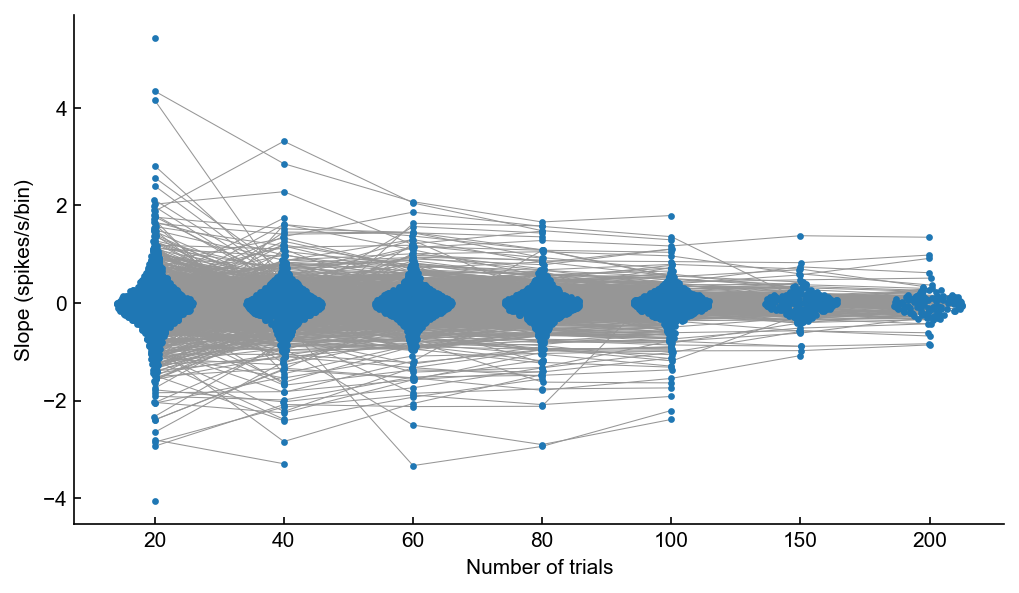

In [190]:
fig, ax = plt.subplots(figsize=(8,4.5))

data = [slps_mean_20t,slps_mean_40t,slps_mean_60t,slps_mean_80t,slps_mean_100t,slps_mean_150t,slps_mean_200t]

X = [np.ones_like(d)*idx for idx,d in enumerate(data)]
Y = data
X,Y = ilep.violin(X,Y,width=0.75)

ax.scatter(X,Y,s=5)
ax.plot(X,Y,color=GOOD_GREY,zorder=-10,lw=0.5)
pass

ax.set_xticklabels(['10','20','40','60','80','100','150','200'])
ax.set_xlabel('Number of trials')
ax.set_ylabel('Slope (spikes/s/bin)')

<ipython-input-199-42f53b6e448d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['10','20','40','60','80','100','150','200'])


Text(0, 0.5, 'SEM')

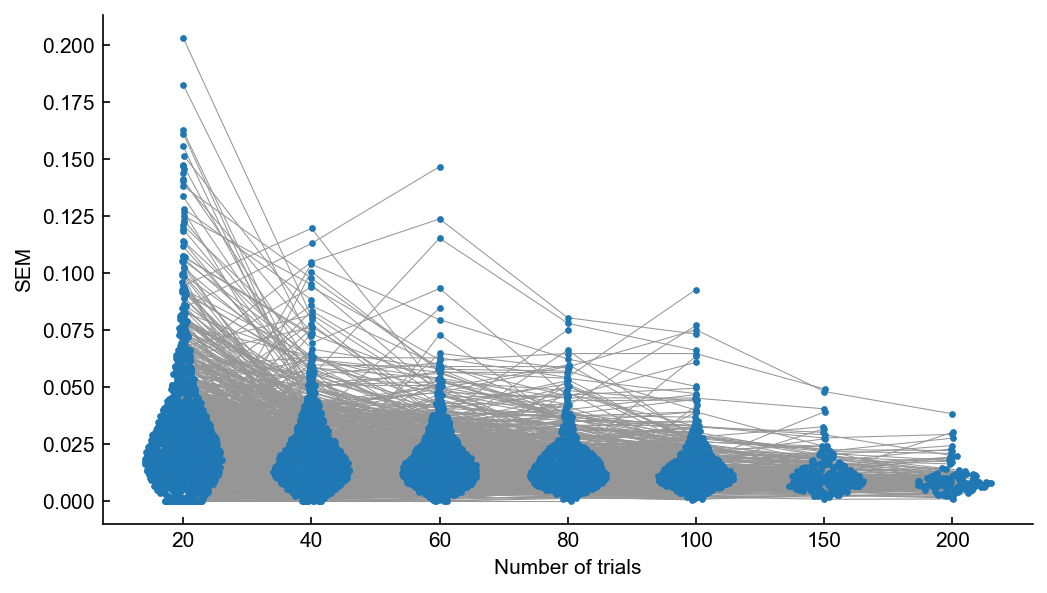

In [199]:
fig, ax = plt.subplots(figsize=(8,4.5))

data = [slps_sem_20t,slps_sem_40t,slps_sem_60t,slps_sem_80t,slps_sem_100t,slps_sem_150t,slps_sem_200t]

X = [np.ones_like(d)*idx for idx,d in enumerate(data)]
Y = data
X,Y = ilep.violin(X,Y,width=0.75)

ax.scatter(X,Y,s=5)
ax.plot(X,Y,color=GOOD_GREY,zorder=-10,lw=0.5)
pass

ax.set_xticklabels(['10','20','40','60','80','100','150','200'])
ax.set_xlabel('Number of trials')
ax.set_ylabel('SEM')

<ipython-input-196-5f98bad9e48d>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,2,4,6,8,10,12,14,16])


Text(0, 0.5, 'Slope (spikes/s/bin)')

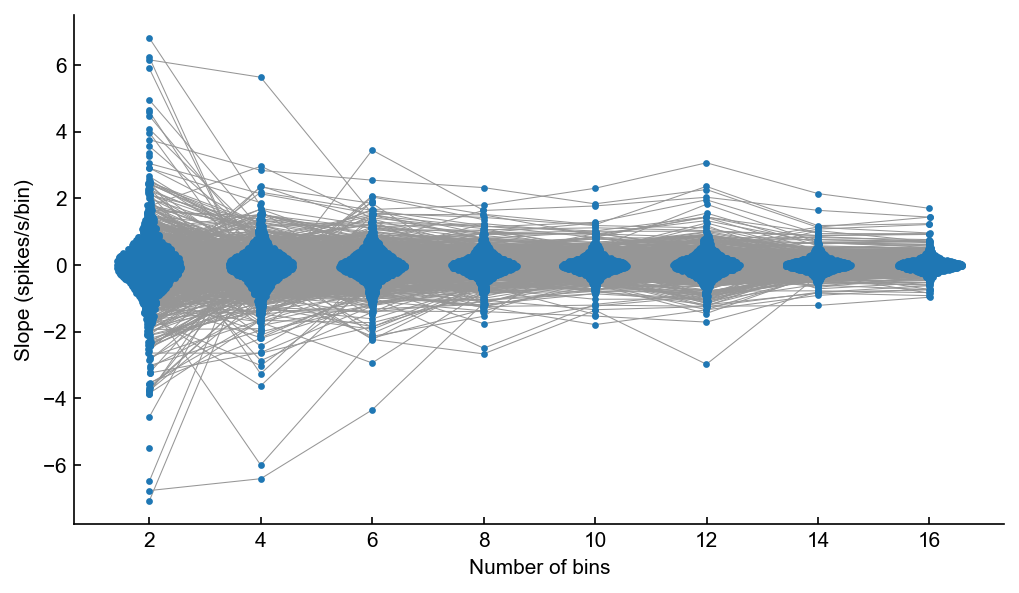

In [196]:
fig, ax = plt.subplots(figsize=(8,4.5))

data = [slps_mean_2b,slps_mean_4b,slps_mean_6b,slps_mean_8b,slps_mean_10b,slps_mean_12b,slps_mean_14b,slps_mean_16b]

X = [np.ones_like(d)*idx for idx,d in enumerate(data)]
Y = data
X,Y = ilep.violin(X,Y,width=0.75)

ax.scatter(X,Y,s=5)
ax.plot(X,Y,color=GOOD_GREY,zorder=-10,lw=0.5)
pass

ax.set_xticklabels([0,2,4,6,8,10,12,14,16])
ax.set_xlabel('Number of bins')
ax.set_ylabel('Slope (spikes/s/bin)')

<ipython-input-197-c4eec0a5b163>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,2,4,6,8,10,12,14,16])


Text(0, 0.5, 'SEM')

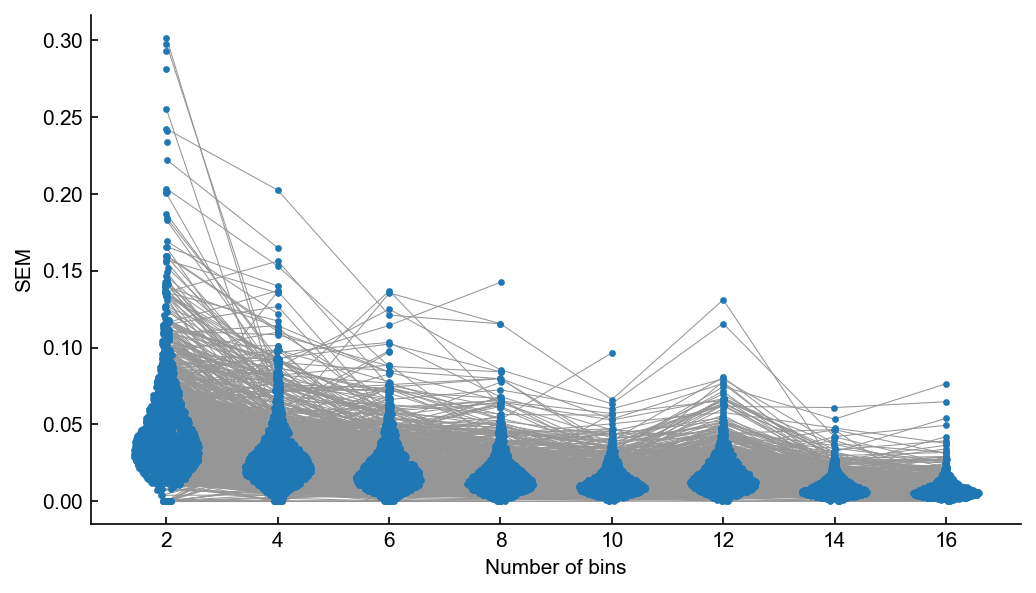

In [197]:
fig, ax = plt.subplots(figsize=(8,4.5))

data = [slps_sem_2b,slps_sem_4b,slps_sem_6b,slps_sem_8b,slps_sem_10b,slps_sem_12b,slps_sem_14b,slps_sem_16b]

X = [np.ones_like(d)*idx for idx,d in enumerate(data)]
Y = data
X,Y = ilep.violin(X,Y,width=0.75)

ax.scatter(X,Y,s=5)
ax.plot(X,Y,color=GOOD_GREY,zorder=-10,lw=0.5)
pass

ax.set_xticklabels([0,2,4,6,8,10,12,14,16])
ax.set_xlabel('Number of bins')
ax.set_ylabel('SEM')

# Refined search

In [202]:
ref_slps_20_trial = []
ref_slps_40_trial = []
ref_slps_60_trial = []
ref_slps_80_trial = []
ref_slps_100_trial = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    conditions = ilep.getAllConditions(sessionfile,clust)
    go_trials = conditions['go'].trials
    
    response_times = (sessionfile.trials.response[go_trials] - sessionfile.trials.starts[go_trials])*1000/sessionfile.meta.fs
    
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=20,maxtrials = 20,verbose=False)
    ref_slps_20_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=40,maxtrials = 40,verbose=False)
    ref_slps_40_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=60,maxtrials = 60,verbose=False)
    ref_slps_60_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=80,maxtrials = 80,verbose=False)
    ref_slps_80_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,True,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=100,maxtrials = 100,verbose=False)
    ref_slps_100_trial.append(slps)

871it [16:00,  1.96it/s]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

872it [16:02,  1.18it/s]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

873it [16:02,  1.28it/s]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

1288it [22:30,  1.05s/it]


In [217]:
offset_ref_slps_20_trial = []
offset_ref_slps_40_trial = []
offset_ref_slps_60_trial = []
offset_ref_slps_80_trial = []
offset_ref_slps_100_trial = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    conditions = ilep.getAllConditions(sessionfile,clust)
    go_trials = conditions['go'].trials
    
    response_times = (sessionfile.trials.response[go_trials] - sessionfile.trials.starts[go_trials])*1000/sessionfile.meta.fs
    
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=20,maxtrials = 20,verbose=False)
    offset_ref_slps_20_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=40,maxtrials = 40,verbose=False)
    offset_ref_slps_40_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=60,maxtrials = 60,verbose=False)
    offset_ref_slps_60_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=80,maxtrials = 80,verbose=False)
    offset_ref_slps_80_trial.append(slps)
    bls,slps = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=100,maxtrials = 100,verbose=False)
    offset_ref_slps_100_trial.append(slps)

43it [00:48,  1.10s/it]<ipython-input-128-127365456771>:102: RuntimeWarning: Mean of empty slice
  avg_across_bins = np.nanmean(spiking_bins[trial_idx_sampled_list,:],axis=0)    #Is this the order that I want to do this in? I think so? Also I think this is actually across trials
871it [18:42,  1.30it/s]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

872it [18:44,  1.09s/it]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

873it [18:44,  1.03it/s]

session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to lo

1288it [27:27,  1.28s/it]


In [207]:
ref_slps_mean_20t = [np.mean(d) for d in ref_slps_20_trial]
ref_slps_mean_40t = [np.mean(d) for d in ref_slps_40_trial]
ref_slps_mean_60t = [np.mean(d) for d in ref_slps_60_trial]
ref_slps_mean_80t = [np.mean(d) for d in ref_slps_80_trial]
ref_slps_mean_100t = [np.mean(d) for d in ref_slps_100_trial]

ref_slps_sem_20t = [sem(d) for d in ref_slps_20_trial]
ref_slps_sem_40t = [sem(d) for d in ref_slps_40_trial]
ref_slps_sem_60t = [sem(d) for d in ref_slps_60_trial]
ref_slps_sem_80t = [sem(d) for d in ref_slps_80_trial]
ref_slps_sem_100t = [sem(d) for d in ref_slps_100_trial]

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [234]:
offset_ref_slps_mean_20t = [np.mean(d) for d in offset_ref_slps_20_trial]
offset_ref_slps_mean_40t = [np.mean(d) for d in offset_ref_slps_40_trial]
offset_ref_slps_mean_60t = [np.mean(d) for d in offset_ref_slps_60_trial]
offset_ref_slps_mean_80t = [np.mean(d) for d in offset_ref_slps_80_trial]
offset_ref_slps_mean_100t = [np.mean(d) for d in offset_ref_slps_100_trial]

offset_ref_slps_sem_20t = [sem(d) for d in offset_ref_slps_20_trial]
offset_ref_slps_sem_40t = [sem(d) for d in offset_ref_slps_40_trial]
offset_ref_slps_sem_60t = [sem(d) for d in offset_ref_slps_60_trial]
offset_ref_slps_sem_80t = [sem(d) for d in offset_ref_slps_80_trial]
offset_ref_slps_sem_100t = [sem(d) for d in offset_ref_slps_100_trial]

<ipython-input-210-47bb606248d4>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,20,40,60,80,100])


Text(0, 0.5, 'Slope (spikes/s/bin)')

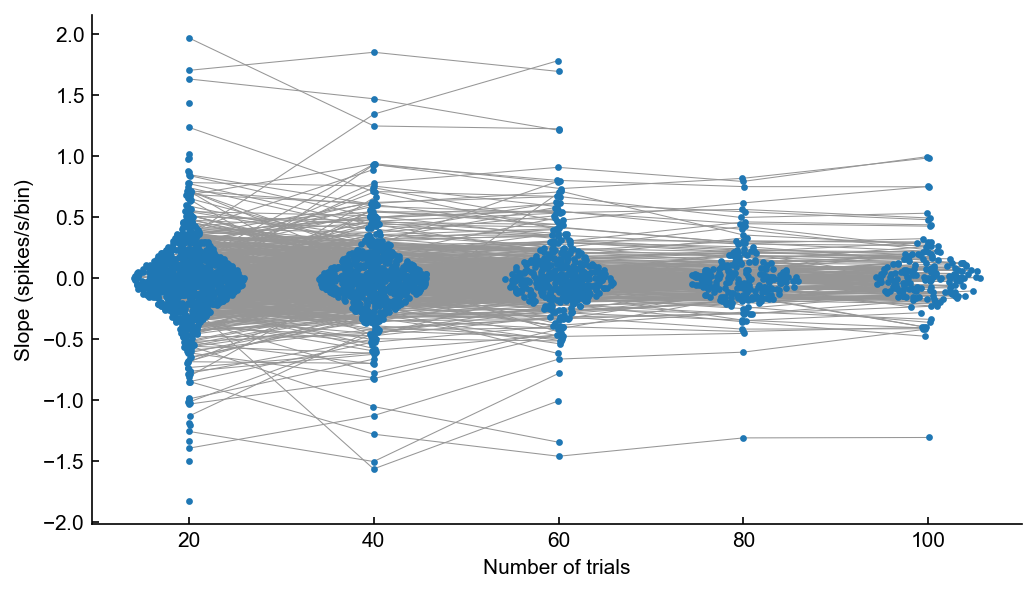

In [210]:
fig, ax = plt.subplots(figsize=(8,4.5))

data = [ref_slps_mean_20t,ref_slps_mean_40t,ref_slps_mean_60t,ref_slps_mean_80t,ref_slps_mean_100t]

X = [np.ones_like(d)*idx for idx,d in enumerate(data)]
Y = data
X,Y = ilep.violin(X,Y,width=0.75)

ax.scatter(X,Y,s=5)
ax.plot(X,Y,color=GOOD_GREY,zorder=-10,lw=0.5)
pass

ax.set_xticklabels([0,20,40,60,80,100])
ax.set_xlabel('Number of trials')
ax.set_ylabel('Slope (spikes/s/bin)')

<ipython-input-212-cfcf1c4cf498>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,20,40,60,80,100])


Text(0, 0.5, 'SEM')

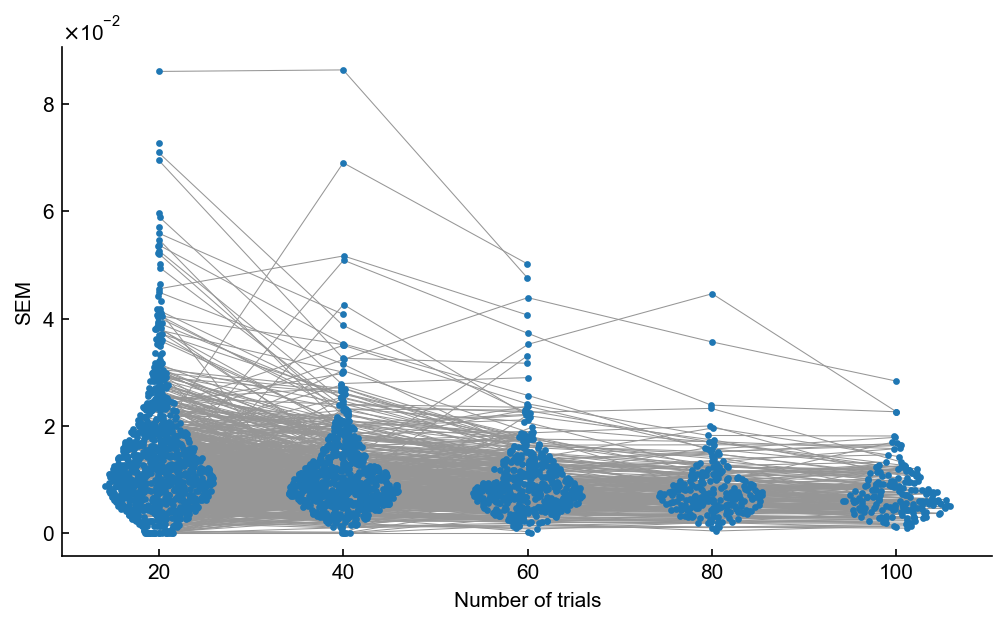

In [212]:
fig, ax = plt.subplots(figsize=(8,4.5))

data = [ref_slps_sem_20t,ref_slps_sem_40t,ref_slps_sem_60t,ref_slps_sem_80t,ref_slps_sem_100t]

X = [np.ones_like(d)*idx for idx,d in enumerate(data)]
Y = data
X,Y = ilep.violin(X,Y,width=0.75)

ax.scatter(X,Y,s=5)
ax.plot(X,Y,color=GOOD_GREY,zorder=-10,lw=0.5)
pass

ax.set_xticklabels([0,20,40,60,80,100])
ax.set_xlabel('Number of trials')
ax.set_ylabel('SEM')

In [214]:
len(ilep.rmnan(ref_slps_sem_60t))

440

In [215]:
len((ref_slps_sem_60t))

1288

In [216]:
440/1288

0.3416149068322981

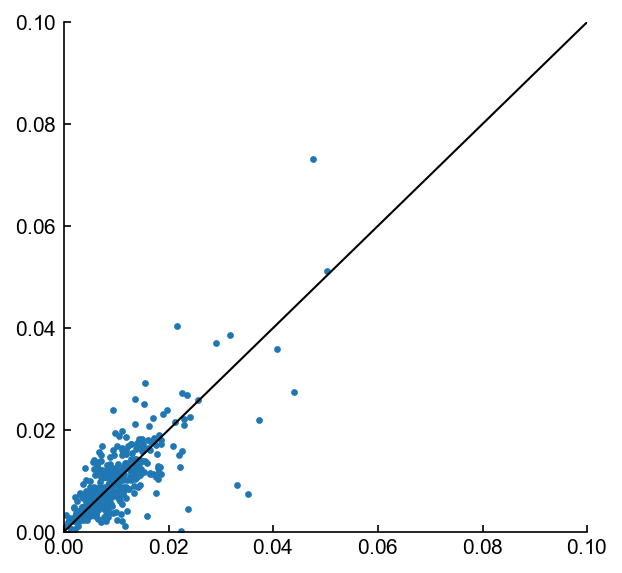

In [256]:
fig, ax = plt.subplots(figsize=(4.5,4.5))

ax.set_xlim([0,0.1])
ax.set_ylim([0,0.1])
ax.plot([0,1],[0,1],lw=1,c='k')

ax.scatter(ref_slps_sem_60t,offset_ref_slps_sem_60t,s=5)

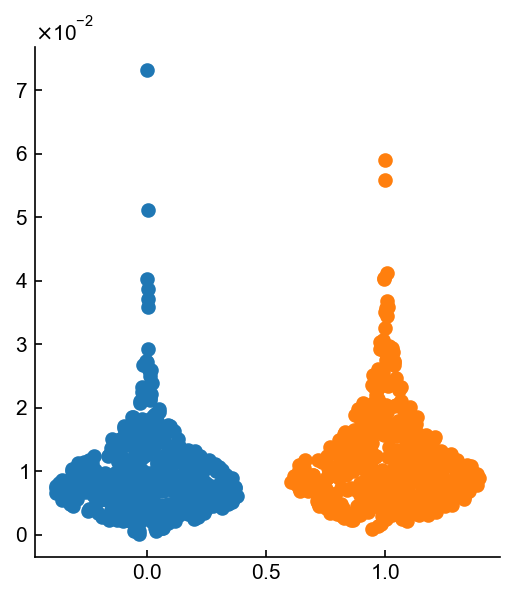

In [251]:
fig, ax = plt.subplots(figsize=(4,4.5))

mask = np.logical_not(np.isnan(ref_slps_sem_60t))
antimask = np.logical_not(mask)

data = np.array(offset_ref_slps_sem_60t)
Y1 = data[mask]
Y2 = data[antimask]

X,Y = ilep.violin(Y1)
ax.scatter(X,Y)

X,Y = ilep.violin(Y2)
ax.scatter(X+1,Y)



In [241]:
len(ilep.rmnan(ref_slps_sem_60t))

440

In [242]:
len(ilep.rmnan(offset_ref_slps_sem_60t))

880

In [231]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    conditions = ilep.getAllConditions(sessionfile,clust)
    go_trials = conditions['go'].trials
    
    _,a = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=20,maxtrials = 20,verbose=False)
    _,b = calculateRampingClusterInternalTEST(sessionfile,clust,False,bootstrap_iterations=25,minrampingwindow=200,maxrampingwindow=300,binsize=25,mintrials=20,maxtrials = 20,verbose=False)
    
    if len(a) > 1:
        break

6it [00:00,  7.41it/s]


In [232]:
a

[-0.8394607843137258,
 -0.9552434221551867,
 -0.9368610692140114,
 -1.0668049270990445,
 -0.9997171945701351,
 -0.9295395508630806,
 -0.8979072398190051,
 -1.1617961287078944,
 -0.9614756158873807,
 -0.9936421149656454,
 -1.0460553879671535,
 -0.9404327970504447,
 -1.0084003686944865,
 -0.9632562426680078,
 -1.0540682084799737,
 -0.8815149991620577,
 -0.9430932629462032,
 -0.891675046086811,
 -1.1617961287078944,
 -1.2149530752471933,
 -0.8786345734875156,
 -0.8365279872632816,
 -0.9142471091000508,
 -0.9936421149656454,
 -1.1617961287078944]

In [233]:
b

[-1.104459946371711,
 -0.8084569297804585,
 -1.1680283224400867,
 -0.9217257415786828,
 -0.9338759007876649,
 -0.8457453494218208,
 -0.8599903636668338,
 -0.9309431037372216,
 -0.9008924082453493,
 -1.1345106418635837,
 -0.9142471091000508,
 -0.9863624937154349,
 -1.104459946371711,
 -1.104459946371711,
 -1.1035696329813982,
 -1.1680283224400867,
 -1.0611907156024802,
 -0.9997171945701351,
 -0.8919892743422158,
 -0.8567328640858061,
 -0.9267533936651584,
 -0.9543531087648747,
 -1.1680283224400867,
 -0.8424878498407922,
 -0.8243778280542986]

(-5.0, 5.0)

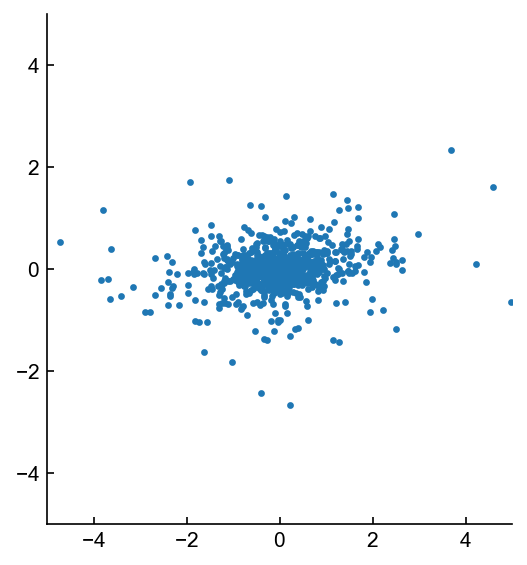

In [149]:
fig, ax = plt.subplots(figsize=(4,4.5))

ax.scatter(slps_mean_2,slps_mean_8,s=5)

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

(-2.0, 2.0)

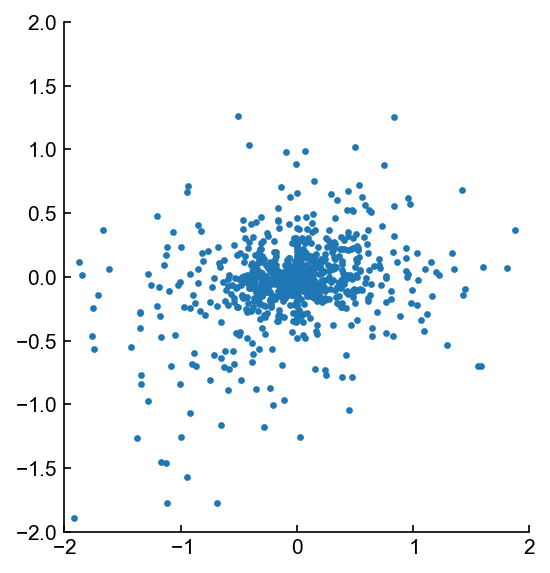

In [147]:
fig, ax = plt.subplots(figsize=(4,4.5))

ax.scatter(slps_mean_20,slps_mean_50,s=5)

ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

(0.0, 0.05)

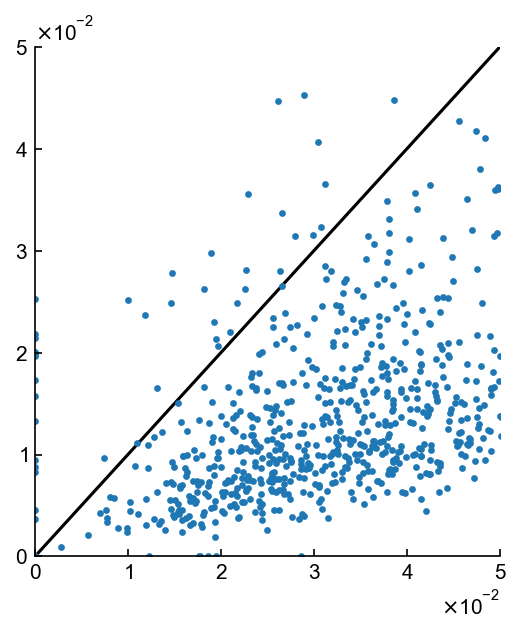

In [146]:
fig, ax = plt.subplots(figsize=(4,4.5))

ax.scatter(slps_sem_2,slps_sem_8,s=5)
ax.plot([0,0.2],[0,0.2],c='k',zorder=-10)

ax.set_xlim([0,0.05])
ax.set_ylim([0,0.05])

(0.0, 0.05)

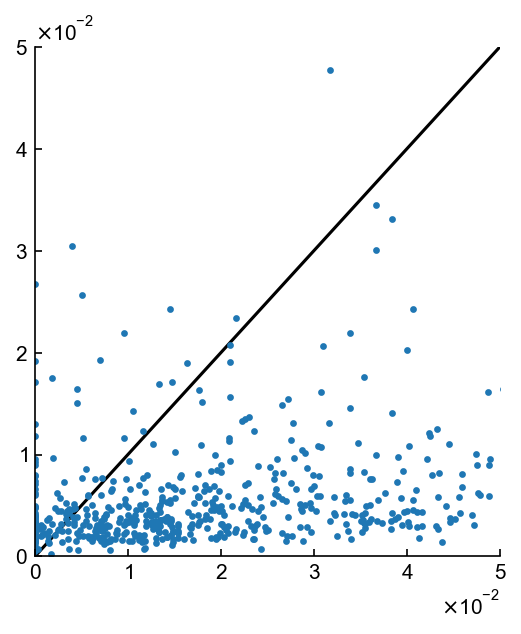

In [143]:
fig, ax = plt.subplots(figsize=(4,4.5))

ax.scatter(slps_sem_20,slps_sem_100,s=5)
ax.plot([0,0.2],[0,0.2],c='k',zorder=-10)

ax.set_xlim([0,0.05])
ax.set_ylim([0,0.05])

In [10]:
len(rampslopes)

283

In [8]:
rampslopes = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        rampslopes.append(sessionfile.responsiveness[clust]['go'].rampingSlopePerSec)
    except:
        pass

1288it [00:08, 152.25it/s]
